# Задание

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<b> Описание услуг </b> 

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

<b> Описание данных </b>

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Цель проекта

Создать модель, которая на основе имеющихся данных будет прогнозировать отток клиентов.

<b> Необходимое требование: </b>

- значение метрики `AUC-ROC` больше 0.85.

В случае близких по основной метрике результатов, стоит учесть значение дополнительной метрики `Accuracy`.

## План проекта

### Загрузка данных и разведывательный анализ

В данном разделе загрузим и оценим данные:
 - изучим общую информация о датафреймах,
 - оценим количество явных пропусков,
 - соединим файлы в один датафрейм

### Предобработка данных

В данном разделе произведем предварительную обработку данных:
- изменим тип данных в столбцах, где это необходиммо для дальнейшей работы,
- удалим дупликаты,
- заполним пропуски, где это возможно,
- обработаем выбросы и некорректные значения (при наличии),
- создадим новые признаки,
- выделим целевой признак

### Исследовательский анализ

В данном разделе произведем исследовательский анализ данных:
 - изучим распределения в численных признаках и значения в категориальных признаках,
 - произведем оценку баланса классов,
 - посмотрим на распределения различных признаков, для разных классов,
 - проверим признаки на мультиколлинеарность

### Обучение моделей

В данном разделе найдем лучшую модель, для этого:
- разобьем датасет на тренировочную и тестовую части,
- создадим класс для кодирования категориальных признаков,
- проведем поиск гиперпараметров для трех моделей (логистическая регрессия, случайный лес, градиентный бустинг) с использованием кросс-валидации,
- выберем лучшую модель с учетом значения метрики `ROC-AUC`

### Тестирование выбранной модели

В данном разделе проверим лучшую модель на тестовой выборке.

## Импорт библиотек и модулей

Импортируем библиотеки и модули

In [1]:
# ! pip install scikit-learn==1.2.2
# ! pip install optuna
# ! pip install catboost
# ! pip install re
# ! pip install seaborn

In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.stats import spearmanr, chi2_contingency
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier

In [3]:
LOCAL_DATA_PATH = '/datasets/final_provider/'
RANDOM_STATE = 100423
CURRENT_DATE = datetime.date(2020, 2, 1)

# Разведочный анализ данных

## Загрузка файлов

Загрузим файлы с данными.

In [4]:
try:
    contract = pd.read_csv('contract_new.csv')
    internet = pd.read_csv('internet_new.csv')
    personal = pd.read_csv('personal_new.csv')
    phone = pd.read_csv('phone_new.csv')
except:
    contract = pd.read_csv(LOCAL_DATA_PATH + 'contract_new.csv')
    internet = pd.read_csv(LOCAL_DATA_PATH + 'internet_new.csv')
    personal = pd.read_csv(LOCAL_DATA_PATH + 'personal_new.csv')
    phone = pd.read_csv(LOCAL_DATA_PATH + 'phone_new.csv')   

## Общая информация о файлах

Изучим общую информацию о датафреймах.

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [8]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Явных пропусков в данных нет. Посмотрим на первые 10 строк из каждого датафрейма.

In [9]:
contract.head(10)

customerID   BeginDate     EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01          No        One year               No   
2  3668-QPYBK  2019-10-01          No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01          No        One year               No   
4  9237-HQITU  2019-09-01          No  Month-to-month              Yes   
5  9305-CDSKC  2019-03-01          No  Month-to-month              Yes   
6  1452-KIOVK  2018-04-01          No  Month-to-month              Yes   
7  6713-OKOMC  2019-04-01          No  Month-to-month               No   
8  7892-POOKP  2017-07-01          No  Month-to-month              Yes   
9  6388-TABGU  2014-12-01  2017-05-01        One year               No   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  
5           Electronic check           99.65      1150.96  
6    Credit card (automatic)           89.10      2058.21  
7               Mailed check           29.75       300.48  
8           Electronic check          104.80      3573.68  
9  Bank transfer (automatic)           56.15      1628.35

Столбцы `BeginDate` и `TotalCharges` имеют тип `object`, но в первом отображена дата, во втором нецелые числа. В дальнейшем изменим тип в этих столбцах.

In [10]:
internet.head(10)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   
5  9305-CDSKC     Fiber optic             No           No              Yes   
6  1452-KIOVK     Fiber optic             No          Yes               No   
7  6713-OKOMC             DSL            Yes           No               No   
8  7892-POOKP     Fiber optic             No           No              Yes   
9  6388-TABGU             DSL            Yes          Yes               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  
5          No         Yes             Yes  
6          No         Yes              No  
7          No          No              No  
8         Yes         Yes             Yes  
9          No          No              No

In [11]:
personal.head(10)

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No
5  9305-CDSKC  Female              0      No         No
6  1452-KIOVK    Male              0      No        Yes
7  6713-OKOMC  Female              0      No         No
8  7892-POOKP  Female              0     Yes         No
9  6388-TABGU    Male              0      No        Yes

In [12]:
phone.head(10)

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
5  7892-POOKP           Yes
6  6388-TABGU            No
7  9763-GRSKD            No
8  7469-LKBCI            No
9  8091-TTVAX           Yes

Датафреймы `internet` и `phone` имеют меньшее количество строк, чем `contract` и `personal`. Посмотрим совпадают ли идентификаторы пользователей в датафреймах.

In [13]:
print('Количество совпадающих значений в столбце customerID в датафреймах internet и contract равно:',
      internet['customerID'].isin(contract['customerID'].unique()).sum())
print('Количество совпадающих значений в столбце customerID в датафреймах personal и contract равно:',
      personal['customerID'].isin(contract['customerID'].unique()).sum())
print('Количество совпадающих значений в столбце customerID в датафреймах phone и contract равно:',
      phone['customerID'].isin(contract['customerID'].unique()).sum())

Количество совпадающих значений в столбце customerID в датафреймах internet и contract равно: 5517
Количество совпадающих значений в столбце customerID в датафреймах personal и contract равно: 7043
Количество совпадающих значений в столбце customerID в датафреймах phone и contract равно: 6361


Как видим, идентификаторы пользователей в датафреймах совпадают. Можно предположить, что в датафреймах `internet` и `phone` меньше строк, так как не все пользователи пользуются интернет-услугами или услугами телефонии. При объединении датафреймов для таких пользователей появятся пропуски в соответствующих колонках. Заполним такие пропуски в разделе `Предобработка данных`.

## Объединение датафреймов

Объединим датафреймы.

In [14]:
data = contract.merge(internet, how='left', on='customerID')
data = data.merge(personal, how='left', on='customerID')
data = data.merge(phone, how='left', on='customerID')
data

customerID   BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE  2017-04-01      No        One year               No   
2     3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3     7795-CFOCW  2016-05-01      No        One year               No   
4     9237-HQITU  2019-09-01      No  Month-to-month              Yes   
...          ...         ...     ...             ...              ...   
7038  6840-RESVB  2018-02-01      No        One year              Yes   
7039  2234-XADUH  2014-02-01      No        One year              Yes   
7040  4801-JZAZL  2019-03-01      No  Month-to-month              Yes   
7041  8361-LTMKD  2019-07-01      No  Month-to-month              Yes   
7042  3186-AJIEK  2014-08-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges InternetService  \
0              Electronic check           29.85        31.04             DSL   
1                  Mailed check           56.95      2071.84             DSL   
2                  Mailed check           53.85       226.17             DSL   
3     Bank transfer (automatic)           42.30       1960.6             DSL   
4              Electronic check           70.70        353.5     Fiber optic   
...                         ...             ...          ...             ...   
7038               Mailed check           84.80       2035.2             DSL   
7039    Credit card (automatic)          103.20       7430.4     Fiber optic   
7040           Electronic check           29.60        325.6             DSL   
7041               Mailed check           74.40        520.8     Fiber optic   
7042  Bank transfer (automatic)          105.65      7251.82     Fiber optic   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0                No          Yes               No          No          No   
1               Yes           No              Yes          No          No   
2               Yes          Yes               No          No          No   
3               Yes           No              Yes         Yes          No   
4                No           No               No          No          No   
...             ...          ...              ...         ...         ...   
7038            Yes           No              Yes         Yes         Yes   
7039             No          Yes              Yes          No         Yes   
7040            Yes           No               No          No          No   
7041             No           No               No          No          No   
7042            Yes           No              Yes         Yes         Yes   

     StreamingMovies  gender  SeniorCitizen Partner Dependents MultipleLines  
0                 No  Female              0     Yes         No           NaN  
1                 No    Male              0      No         No            No  
2                 No    Male              0      No         No            No  
3                 No    Male              0      No         No           NaN  
4                 No  Female              0      No         No            No  
...              ...     ...            ...     ...        ...           ...  
7038             Yes    Male              0     Yes        Yes           Yes  
7039             Yes  Female              0     Yes        Yes           Yes  
7040              No  Female              0     Yes        Yes           NaN  
7041              No    Male              1     Yes         No           Yes  
7042             Yes    Male              0      No         No            No  

[7043 rows x 20 columns]

Переименуем столбы в полученном датафрейме.

In [15]:
data.rename(columns={old_name : '_'.join(re.findall('[A-Z]+[a-z]*', old_name[0].upper() + old_name[1:])).lower() 
                     for old_name in data.columns}, inplace=True)
data.head(10)

customer_id  begin_date    end_date            type paperless_billing  \
0  7590-VHVEG  2020-01-01          No  Month-to-month               Yes   
1  5575-GNVDE  2017-04-01          No        One year                No   
2  3668-QPYBK  2019-10-01          No  Month-to-month               Yes   
3  7795-CFOCW  2016-05-01          No        One year                No   
4  9237-HQITU  2019-09-01          No  Month-to-month               Yes   
5  9305-CDSKC  2019-03-01          No  Month-to-month               Yes   
6  1452-KIOVK  2018-04-01          No  Month-to-month               Yes   
7  6713-OKOMC  2019-04-01          No  Month-to-month                No   
8  7892-POOKP  2017-07-01          No  Month-to-month               Yes   
9  6388-TABGU  2014-12-01  2017-05-01        One year                No   

              payment_method  monthly_charges total_charges internet_service  \
0           Electronic check            29.85         31.04              DSL   
1               Mailed check            56.95       2071.84              DSL   
2               Mailed check            53.85        226.17              DSL   
3  Bank transfer (automatic)            42.30        1960.6              DSL   
4           Electronic check            70.70         353.5      Fiber optic   
5           Electronic check            99.65       1150.96      Fiber optic   
6    Credit card (automatic)            89.10       2058.21      Fiber optic   
7               Mailed check            29.75        300.48              DSL   
8           Electronic check           104.80       3573.68      Fiber optic   
9  Bank transfer (automatic)            56.15       1628.35              DSL   

  online_security online_backup device_protection tech_support streaming_tv  \
0              No           Yes                No           No           No   
1             Yes            No               Yes           No           No   
2             Yes           Yes                No           No           No   
3             Yes            No               Yes          Yes           No   
4              No            No                No           No           No   
5              No            No               Yes           No          Yes   
6              No           Yes                No           No          Yes   
7             Yes            No                No           No           No   
8              No            No               Yes          Yes          Yes   
9             Yes           Yes                No           No           No   

  streaming_movies  gender  senior_citizen partner dependents multiple_lines  
0               No  Female               0     Yes         No            NaN  
1               No    Male               0      No         No             No  
2               No    Male               0      No         No             No  
3               No    Male               0      No         No            NaN  
4               No  Female               0      No         No             No  
5              Yes  Female               0      No         No            Yes  
6               No    Male               0      No        Yes            Yes  
7               No  Female               0      No         No            NaN  
8              Yes  Female               0     Yes         No            Yes  
9               No    Male               0      No        Yes             No

# Предобработка данных

## Изменение типов данных

Изменим тиы данных в некоторых столбцах:
- столбец `begin_date` приведем к типу `datetime`
- столбец `total_charges` приведем к типу `float`

Посмотрим на уникальные значения в столбце `begin_date`.

In [16]:
data['begin_date'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

В столбце все даты в одинаковом формате, причем все они соответствуют первому числу месяца. Переведем их в формат `datetime`.

In [17]:
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')

Преобразуем значения в столбце `total_charges` в тип `float`. Но сначала проверим этот столбец на наличие значений, тип которых не получится изменить.

In [18]:
def float_check(x):
    try:
        float(x)
        return False
    except:
        return True

In [19]:
data[data['total_charges'].apply(float_check)][['begin_date', 'end_date', 'monthly_charges', 'total_charges']]

begin_date end_date  monthly_charges total_charges
488  2020-02-01       No            52.55              
753  2020-02-01       No            20.25              
936  2020-02-01       No            80.85              
1082 2020-02-01       No            25.75              
1340 2020-02-01       No            56.05              
3331 2020-02-01       No            19.85              
3826 2020-02-01       No            25.35              
4380 2020-02-01       No            20.00              
5218 2020-02-01       No            19.70              
6670 2020-02-01       No            73.35              
6754 2020-02-01       No            61.90

Не удалось преобразовать значения для клиентов, которые начали пользоваться услугами на момент сбора данных, поэтому значения в столбце `total_charges` у них заполнены. Заменим их нулями.

In [20]:
def str_to_float(x):
    try:
        return float(x)
    except:
        return 0

In [21]:
data['total_charges'] = data['total_charges'].apply(str_to_float)

In [22]:
data.head(5)

customer_id begin_date end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01       No  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01       No        One year                No   
2  3668-QPYBK 2019-10-01       No  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01       No        One year                No   
4  9237-HQITU 2019-09-01       No  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges internet_service  \
0           Electronic check            29.85          31.04              DSL   
1               Mailed check            56.95        2071.84              DSL   
2               Mailed check            53.85         226.17              DSL   
3  Bank transfer (automatic)            42.30        1960.60              DSL   
4           Electronic check            70.70         353.50      Fiber optic   

  online_security online_backup device_protection tech_support streaming_tv  \
0              No           Yes                No           No           No   
1             Yes            No               Yes           No           No   
2             Yes           Yes                No           No           No   
3             Yes            No               Yes          Yes           No   
4              No            No                No           No           No   

  streaming_movies  gender  senior_citizen partner dependents multiple_lines  
0               No  Female               0     Yes         No            NaN  
1               No    Male               0      No         No             No  
2               No    Male               0      No         No             No  
3               No    Male               0      No         No            NaN  
4               No  Female               0      No         No             No

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    5517 non-null   object        
 10  online_backup      5517 non-null   object        
 11  device_protection  5517 non-null   object        
 12  tech_support       5517 non-null   object        
 13  streaming_tv       5517 non-null   object        
 14  streamin

## Поиск дупликатов

Проверим датафрейм на наличие дупликатов.

In [24]:
data.duplicated().sum()

0

Проверим, не встречаются ли одинаковые пользователи.

In [25]:
data['customer_id'].duplicated().sum()

0

## Замена пропусков

Заменим пропуски в столбцах из датафреймов `internet` и `phone`. Так как пропуски возникли из-зи отсутствия некоторых пользователей в этих датафреймах, предположим, что у таких пользователей нет интернет-услуг или услуг телефонии. 

In [26]:
na_columns = ['internet_service', 'online_security', 'online_backup','device_protection',
              'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [27]:
data[na_columns] = data[na_columns].fillna('No')

Проверим датафрейм на пропуски.

In [28]:
data.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

## Создание целевого признака

В качестве целевого признака будем считать уход клиента. Для таких клиентов в столбце `end_date` указана дата.

In [29]:
def target_create(x):
    if x == 'No':
        return 0
    else:
        return 1

In [30]:
data['refused'] = data['end_date'].apply(target_create)

In [31]:
data[['end_date', 'refused']].head(10)

end_date  refused
0          No        0
1          No        0
2          No        0
3          No        0
4          No        0
5          No        0
6          No        0
7          No        0
8          No        0
9  2017-05-01        1

## Создание новых признаков

Значение даты начала в явном виде не удобно использовать, так как для ушедших клиентов нужно учитывать еще и дату ухода. Поэтому создадим признак со значениями длительности использования данного оператора. Так как все даты подключения - первое число месяца, то в качестве длительности удобно использовать количество месяцев. Но сначала заменим значения `No` в столбце `end_date`, на актуальную для данных дату. 

In [32]:
data['end_date'] = data['end_date'].where(data['end_date'] != 'No', str(CURRENT_DATE))

In [33]:
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d')

In [34]:
data['begin_date']

0      2020-01-01
1      2017-04-01
2      2019-10-01
3      2016-05-01
4      2019-09-01
          ...    
7038   2018-02-01
7039   2014-02-01
7040   2019-03-01
7041   2019-07-01
7042   2014-08-01
Name: begin_date, Length: 7043, dtype: datetime64[ns]

In [35]:
data['duration'] = (data['end_date'].dt.month - data['begin_date'].dt.month) + \
                    12 * (data['end_date'].dt.year - data['begin_date'].dt.year)

Добавим признак для подсчета продолжительности периода оказания услуг в днях.

In [36]:
data['duration_in_days'] = (data['end_date'] - data['begin_date']).dt.days

Создадим признак, указывающий закончился ли период договора (в случае договора на 1 или 2 года).

In [37]:
def end_of_period(row):
    if row['type'] == 'One year':
        if row['duration'] % 12 == 0:
            return 'Yes'
        else:
            return 'No'
    if row['type'] == 'Two year':
        if row['duration'] % 24 == 0:
            return 'Yes'
        else:
            return 'No'        
    return 'Month-to-month'

In [38]:
data['end_of_period'] = data[['type', 'duration']].apply(end_of_period, axis=1)

Добавим признак учитывающий количество подключенных услуг.

In [39]:
def numb_of_services(row):
    count = 0
    for service in row:
        if service == 'Yes':
            count += 1
    return count

In [40]:
data['numb_of_services'] = data[['online_security', 'online_backup', 'device_protection', 
                                       'tech_support', 'streaming_tv', 'streaming_movies']].apply(numb_of_services, axis=1)

Проверим полученные признаки.

In [41]:
data[['begin_date', 'end_date', 'type', 'duration', 'duration_in_days', 'end_of_period', 'online_security', 'online_backup',
      'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'numb_of_services']].head(10)

begin_date   end_date            type  duration  duration_in_days  \
0 2020-01-01 2020-02-01  Month-to-month         1                31   
1 2017-04-01 2020-02-01        One year        34              1036   
2 2019-10-01 2020-02-01  Month-to-month         4               123   
3 2016-05-01 2020-02-01        One year        45              1371   
4 2019-09-01 2020-02-01  Month-to-month         5               153   
5 2019-03-01 2020-02-01  Month-to-month        11               337   
6 2018-04-01 2020-02-01  Month-to-month        22               671   
7 2019-04-01 2020-02-01  Month-to-month        10               306   
8 2017-07-01 2020-02-01  Month-to-month        31               945   
9 2014-12-01 2017-05-01        One year        29               882   

    end_of_period online_security online_backup device_protection  \
0  Month-to-month              No           Yes                No   
1              No             Yes            No               Yes   
2  Month-to-month             Yes           Yes                No   
3              No             Yes            No               Yes   
4  Month-to-month              No            No                No   
5  Month-to-month              No            No               Yes   
6  Month-to-month              No           Yes                No   
7  Month-to-month             Yes            No                No   
8  Month-to-month              No            No               Yes   
9              No             Yes           Yes                No   

  tech_support streaming_tv streaming_movies  numb_of_services  
0           No           No               No                 1  
1           No           No               No                 2  
2           No           No               No                 2  
3          Yes           No               No                 3  
4           No           No               No                 0  
5           No          Yes              Yes                 3  
6           No          Yes               No                 2  
7           No           No               No                 1  
8          Yes          Yes              Yes                 4  
9           No           No               No                 2

## Удаление ненужных признаков

Признаки с датой конца использования легко связать с целевой переменной, как и дату начала использования совместно с длительностью. Поэтому удалим их. Также удалим идентификаторы клиентов. 

In [42]:
data = data.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

In [43]:
data

type paperless_billing             payment_method  \
0     Month-to-month               Yes           Electronic check   
1           One year                No               Mailed check   
2     Month-to-month               Yes               Mailed check   
3           One year                No  Bank transfer (automatic)   
4     Month-to-month               Yes           Electronic check   
...              ...               ...                        ...   
7038        One year               Yes               Mailed check   
7039        One year               Yes    Credit card (automatic)   
7040  Month-to-month               Yes           Electronic check   
7041  Month-to-month               Yes               Mailed check   
7042        Two year               Yes  Bank transfer (automatic)   

      monthly_charges  total_charges internet_service online_security  \
0               29.85          31.04              DSL              No   
1               56.95        2071.84              DSL             Yes   
2               53.85         226.17              DSL             Yes   
3               42.30        1960.60              DSL             Yes   
4               70.70         353.50      Fiber optic              No   
...               ...            ...              ...             ...   
7038            84.80        2035.20              DSL             Yes   
7039           103.20        7430.40      Fiber optic              No   
7040            29.60         325.60              DSL             Yes   
7041            74.40         520.80      Fiber optic              No   
7042           105.65        7251.82      Fiber optic             Yes   

     online_backup device_protection tech_support  ...  gender senior_citizen  \
0              Yes                No           No  ...  Female              0   
1               No               Yes           No  ...    Male              0   
2              Yes                No           No  ...    Male              0   
3               No               Yes          Yes  ...    Male              0   
4               No                No           No  ...  Female              0   
...            ...               ...          ...  ...     ...            ...   
7038            No               Yes          Yes  ...    Male              0   
7039           Yes               Yes           No  ...  Female              0   
7040            No                No           No  ...  Female              0   
7041            No                No           No  ...    Male              1   
7042            No               Yes          Yes  ...    Male              0   

     partner  dependents multiple_lines refused duration  duration_in_days  \
0        Yes          No             No       0        1                31   
1         No          No             No       0       34              1036   
2         No          No             No       0        4               123   
3         No          No             No       0       45              1371   
4         No          No             No       0        5               153   
...      ...         ...            ...     ...      ...               ...   
7038     Yes         Yes            Yes       0       24               730   
7039     Yes         Yes            Yes       0       72              2191   
7040     Yes         Yes             No       0       11               337   
7041     Yes          No            Yes       0        7               215   
7042      No          No             No       0       66              2010   

       end_of_period  numb_of_services  
0     Month-to-month                 1  
1                 No                 2  
2     Month-to-month                 2  
3                 No                 3  
4     Month-to-month                 0  
...              ...               ...  
7038             Yes                 5  
7039             Yes                 4  
7040  Month-to-month           

## Вывод

В процессе предобработки данных были произведены следующие действия:
- изменены типы данных двух столбцов (`begin_date` и `total_charges`),
- заменены пропуски, полученные при слиянии датафреймов,
- создан целевой признак на основе столбца `end_data`,
- созданы 3 новых признака (`duration`, `end_of_period`, `numb_of_services`)
- удалены признаки, которые не будут использоваться при прогнозировании.

# Исследовательский анализ данных

Выделим категориальные и численные признаки.

In [44]:
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'refused', 'duration', 'duration_in_days', 'end_of_period',
       'numb_of_services'],
      dtype='object')

In [45]:
numb_cols = ['monthly_charges', 'total_charges', 'duration', 'duration_in_days', 'numb_of_services']
cat_cols = ['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security',
            'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
            'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines', 'end_of_period']

## Распределения в численных признаках

Найдем распределения для 3 типов данных:
- для всех данных,
- для оставшихся пользователей,
- для ушедших пользователей

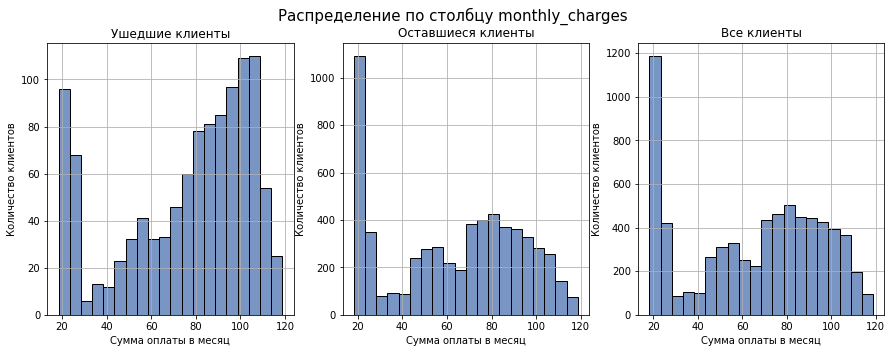

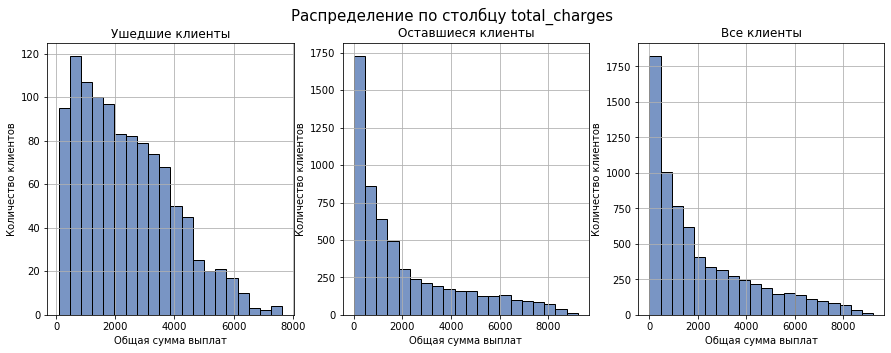

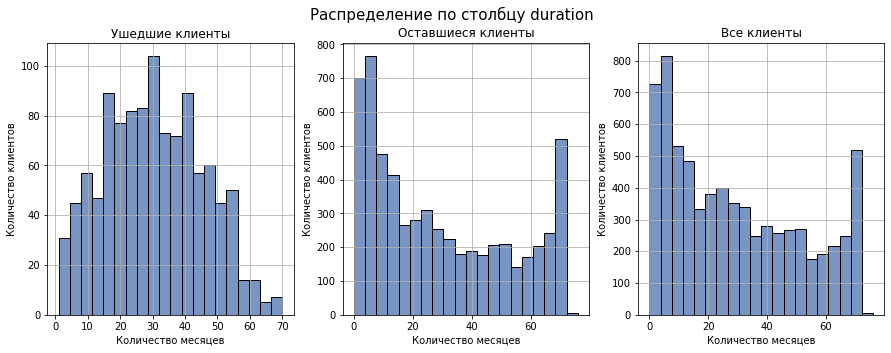

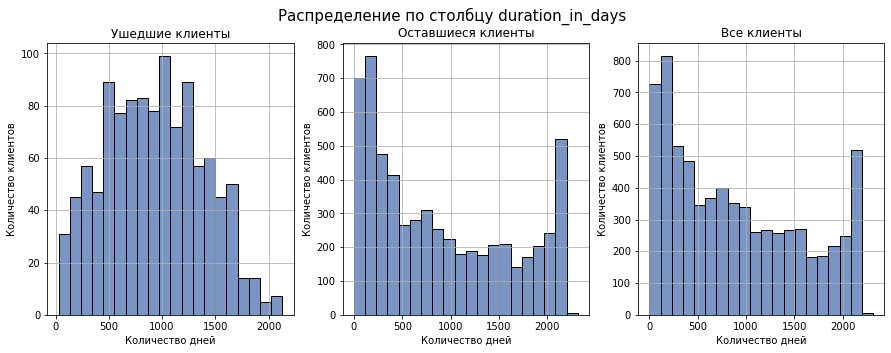

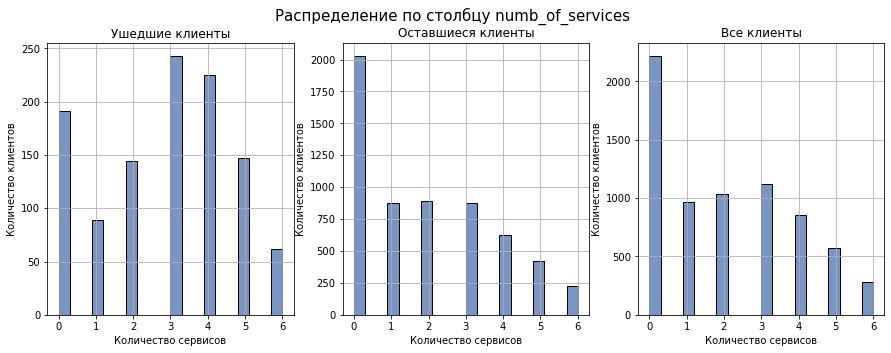

In [46]:
plt.style.use('seaborn-deep')
xlabel_dict = {'monthly_charges' : 'Сумма оплаты в месяц',
               'total_charges' : 'Общая сумма выплат',
               'duration' : 'Количество месяцев',
               'duration_in_days' : 'Количество дней',
               'numb_of_services' : 'Количество сервисов'}
for col in numb_cols:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f'Распределение по столбцу {col}', fontsize=15)
    for i, customer_type in enumerate(['Ушедшие клиенты', 'Оставшиеся клиенты', 'Все клиенты']):
        sns.histplot(data.query('refused != @i')[col], ax=axes[i], bins=20)
        axes[i].set_title(customer_type, fontsize=12)
        axes[i].set(xlabel=xlabel_dict[col], ylabel='Количество клиентов')
        axes[i].grid(True)
    plt.show()

Как видно из гистограмм распределения оставшихся клиентов и всех клиентов очень похожи. Как видно из количества клиентов на этих гистограммах, их сходство вызвано тем, что большую часть от всех клиентов составляют оставшиеся клиенты.

По гистограммам ушедших клиентов можно выделить следующие отличия от оставшихся:
- большое количество имели ежемесяцный платеж выше среднего (от 70 до 120), тогда как среди оставшихся с такими же платежами гораздо меньшая часть,
- доля клиентов с общими платежами от 500 до 6000 выше, чем у оставшихся,
- большая часть ушедших клиентов пользовалась услугами от 10 до 55 месяцев, тогда как у оставшихся большее количество новых клиентов (до 10 месяцев), либо давних (больше 70 месяцев),
- доля ушедших клиентов пользующихся от 2 до 5 услуг больше, чем у оставшихся.

На основании этих гистограмм можно сделать вывод, что чаще уходят клиенты, которые пользовались услугами от 1 до 5 лет, с ежемесячными платежами выше среднего и подключенные к 2-5 услугам.

## Распределения в категориальных признаках

Распределения в категориальных признаках рассмотрим также, для 3 типов данных.

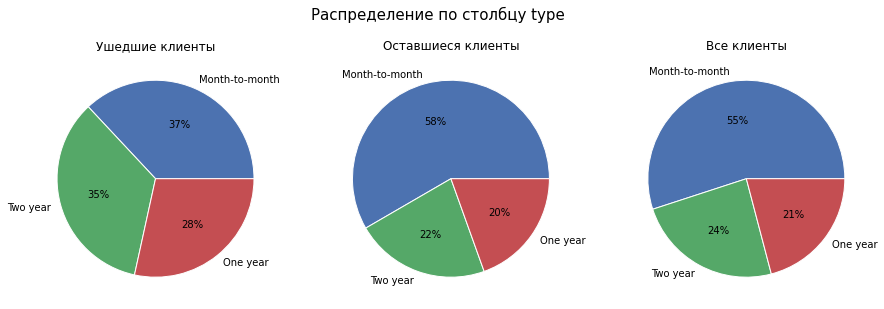

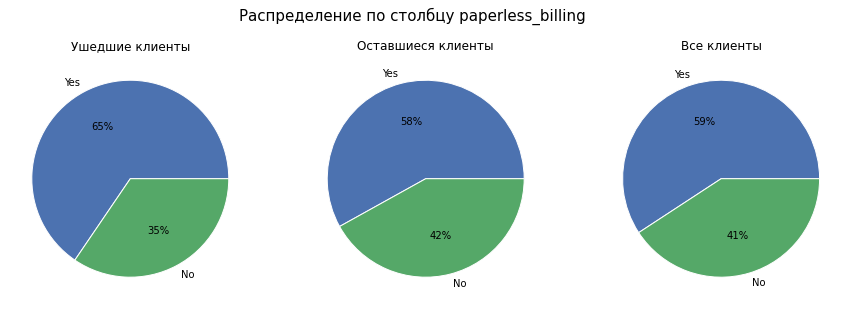

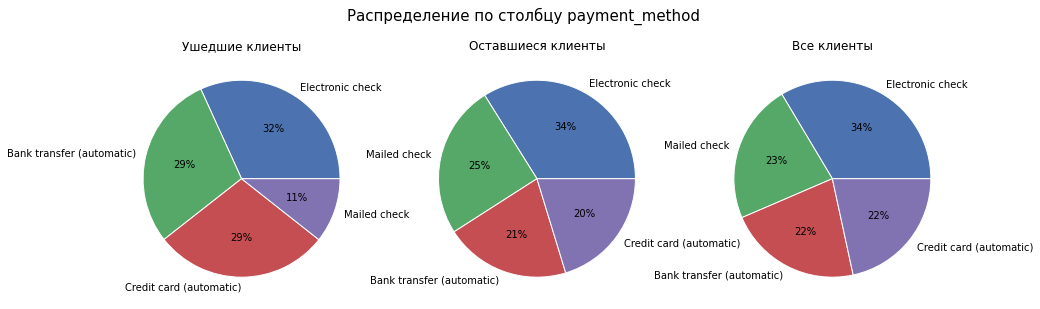

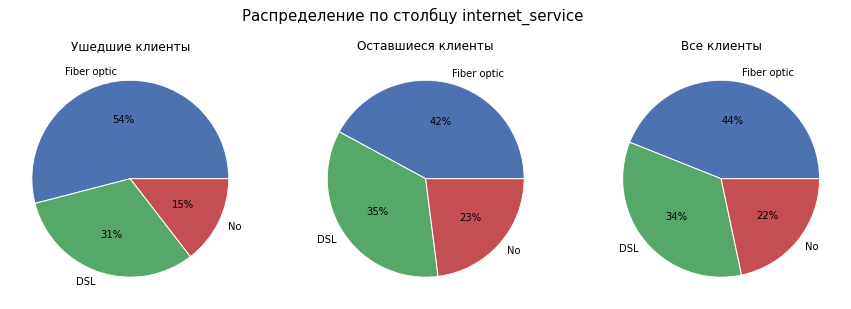

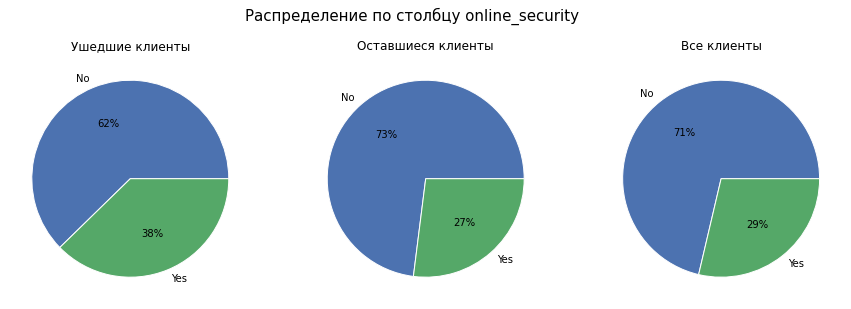

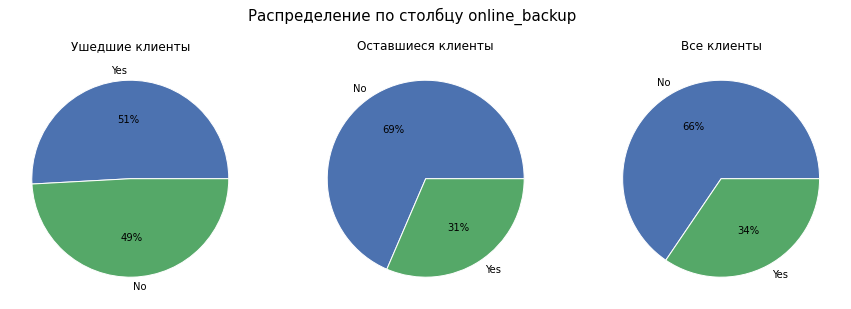

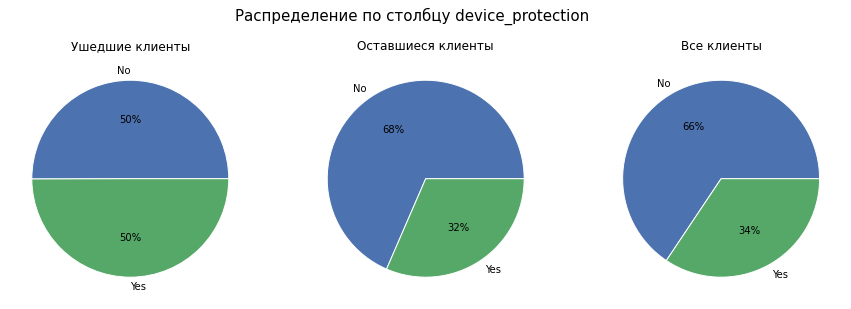

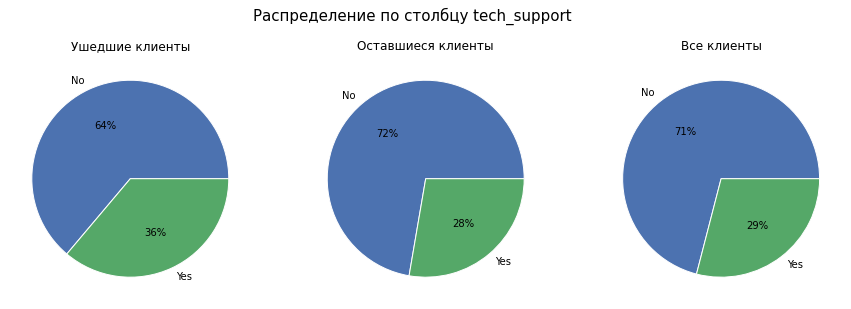

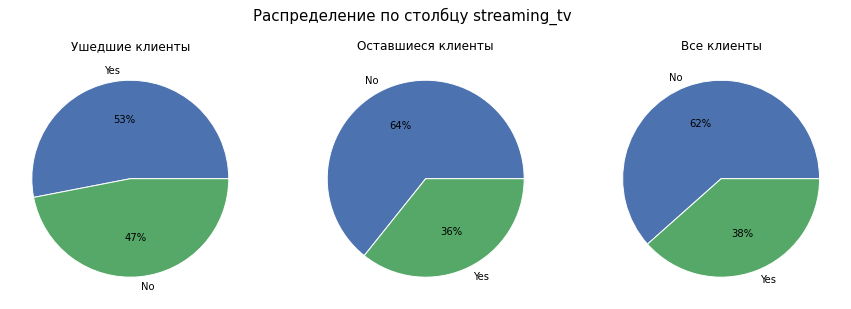

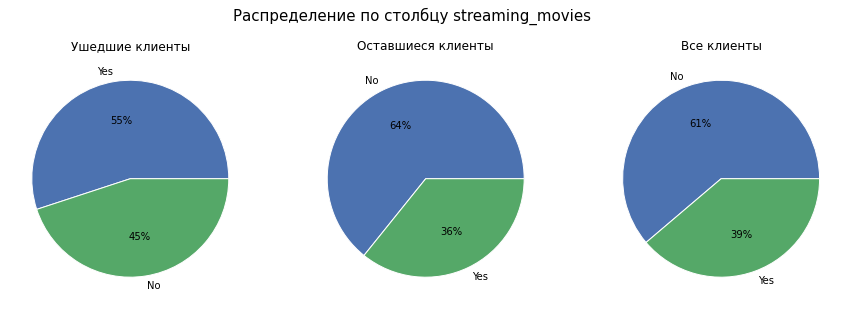

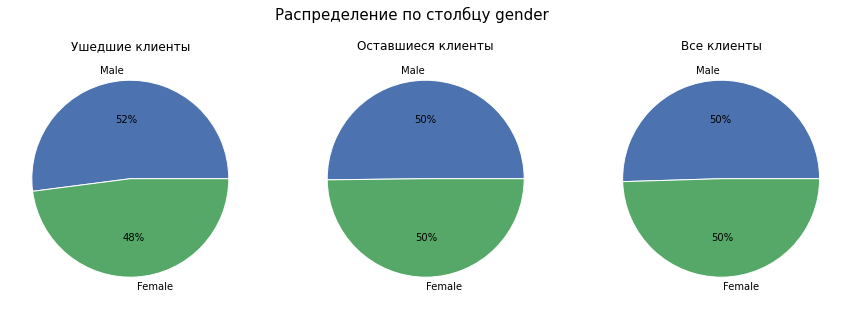

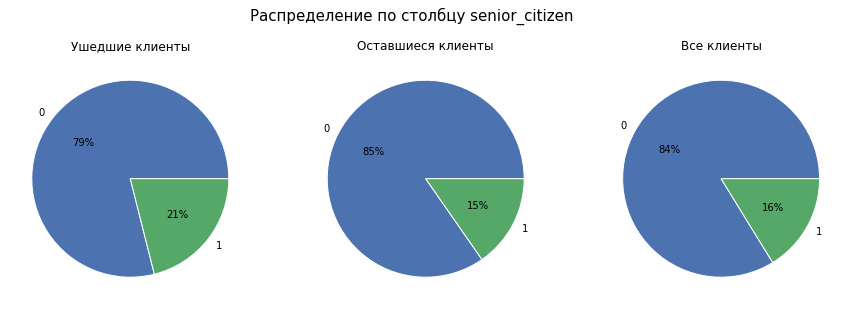

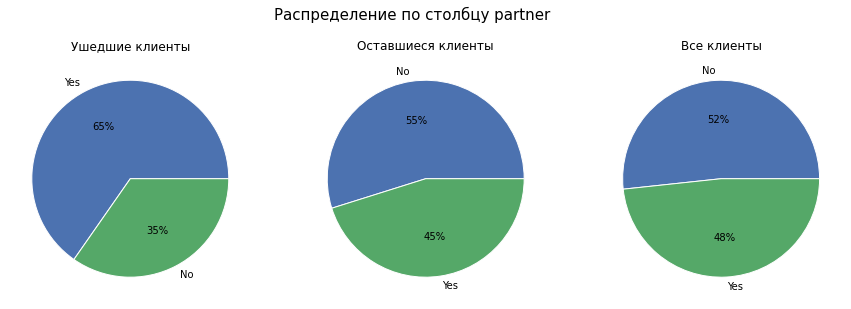

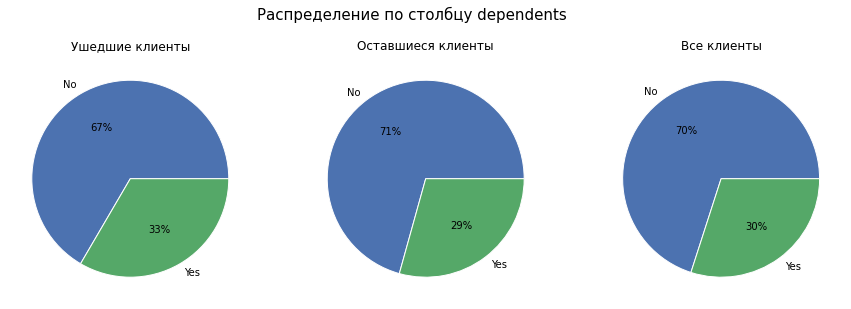

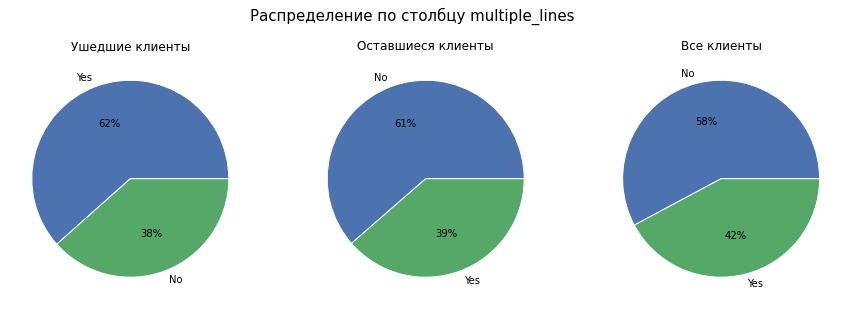

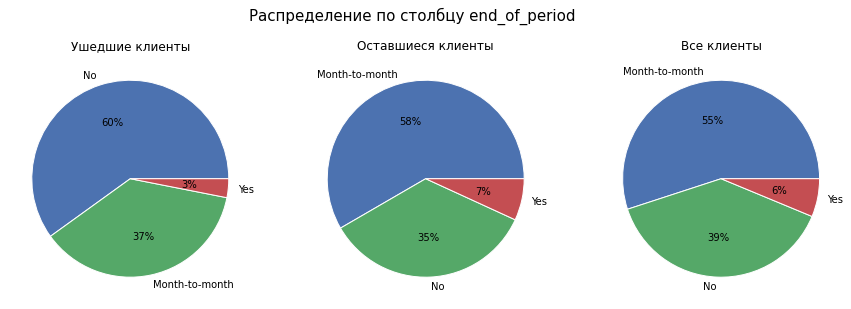

In [47]:
wp = { 'linewidth' : 1, 'edgecolor' : "white" }
for col in cat_cols:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f'Распределение по столбцу {col}', fontsize=15)
    for i, customer_type in enumerate(['Ушедшие клиенты', 'Оставшиеся клиенты', 'Все клиенты']):
        data.query('refused != @i')[col].value_counts().plot(kind='pie', ax=axes[i], autopct='%1.0f%%', wedgeprops = wp)
        axes[i].set_title(customer_type, fontsize=12)
        axes[i].set(ylabel=None)
    plt.show()

По диаграммам распределений категориальных признаков также можно отметить сходство для оставшихся и всех клиентов.

Для ушедших клиентов стоит отметить различия по некоторым признакам по отношению к оставшимся:
- доля клиентов оплачивающих услуги по договору на 1-2 года (особенно на 2) больше, а ежемесячно меньше,
- часть клиентов, пользующихся возможностью получения электронного чека, немного больше,
- больше доля клиентов, оплачивающих кредитной картой и банковским переводом, но меньше оплачивающих через чек, отправленный по почте,
- часть клиентов, подключенных к интернету через оптоволоконный кабель, выше, а неподключенных ниже,
- больше доля клиентов с подключенными услугами, особенно разницу можно выделить в следующих услугах: облачное хранилище файлов для резервного копирования данных, антивирус, стриминговое телевидение и каталог фильмов,
- немного больше доля клиентов пожилого возраста,
- по полу и наличию детей разница совсем небольшая,
- среди ушедших значительно больше доля клиентов, имеющих партнера,
- доля клиентов, использующих стационарную телефонную связь с возможностью подключения к нескольким телефонным линиям одновременно, выше,
- доля клиентов ушедших до окончания договора (для клиентов использующих оплату за 1 или 2 года) больше, чем у оставшихся.

На основании этих диаграмм можно сделать вывод, что чаще уходят клиенты, использующие большее количество предоставляемых услуг, оплачивающих по договору на 1-2 года (причем уходят гораздо чаще до окончания этого срока) и имеющие подключение к интернету и стационарному телефону. Также стоит отметить, что среди ушедших больше часть клиентов имеет пратнера. 

## Баланс классов

Рассмотрим отношение ушедших клиентов к оставшимся.

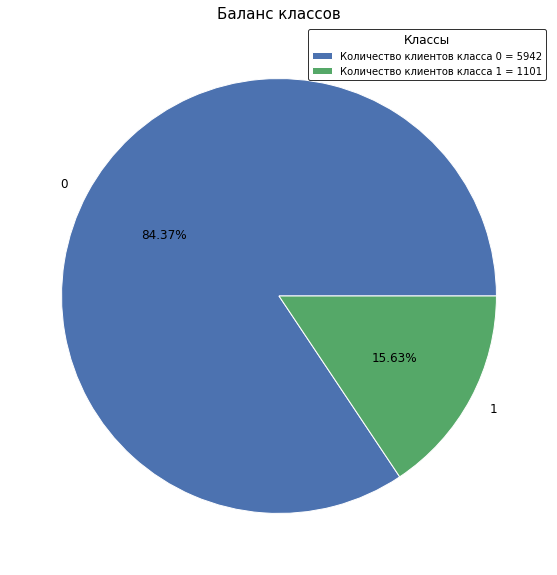

In [48]:
class_balance = data['refused'].value_counts()
plt.figure(figsize=(10, 10))
class_balance.plot(kind='pie', autopct='%.2f%%', fontsize=12, wedgeprops = wp)
plt.title('Баланс классов', fontsize=15)
plt.ylabel(None)
plt.legend(labels=[f'Количество клиентов класса {i} = {numb}' for i, numb in zip(class_balance.index, class_balance.values)],
           frameon = True, edgecolor = 'black', title = 'Классы', fontsize=10, title_fontsize=12)
plt.show()

Количество ушедших клиентов более чем в 5 раз меньше оставшихся.

## Корреляция признаков

Для проверки на корреляцию числовых признаков используем корреляцию Спирмена.

In [49]:
rho, p = spearmanr(data[numb_cols])

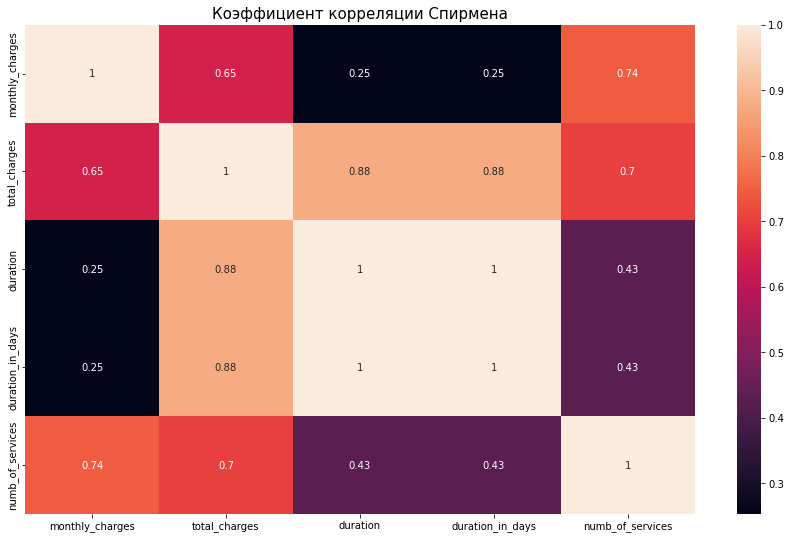

In [50]:
plt.figure(figsize=(15, 9))
sns.heatmap(rho, annot=True, xticklabels=numb_cols, yticklabels=numb_cols)
plt.title('Коэффициент корреляции Спирмена', fontsize=15)
plt.show()

Как видим из тепловой карты, есть линейная зависимость между признаками `duration` и `duration_in_day`, высокая корреляция наблюдается между продолжительностью и общей суммой выплат (это можно объяснить тем, что общая сумма выплат сумма ежемесячных платежей, то есть средний платеж умноженный на количество месяцев, что является линейной зависимостью) и между количеством сервисов и обеими выплатами (чем больше сервисов, тем выше тарифная плата). Так же заметную корреляционную связь видим между общей суммой выплат и ежемесячной суммой выплат.

Так же оценим значимости коэффициентов.

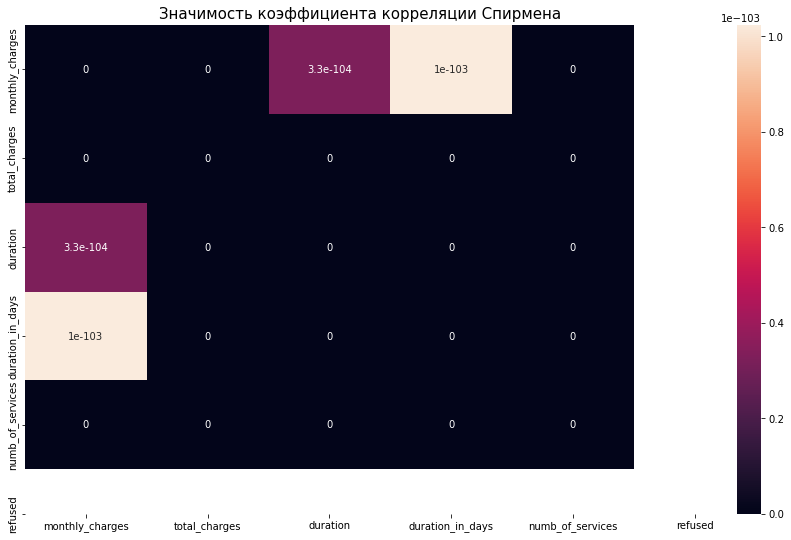

In [51]:
plt.figure(figsize=(15, 9))
sns.heatmap(p, annot=True, xticklabels=numb_cols + ['refused'], yticklabels=numb_cols + ['refused'])
plt.title('Значимость коэффициента корреляции Спирмена', fontsize=15)
plt.show()

Как видим, значения вероятностей крайне малы, что говорит о том, что вероятность наблюдения данных при условии, что образцы не коррелированы, очень маловероятна.

Рассмотрим точечные графики, отображающие попарные отношения между признаками.

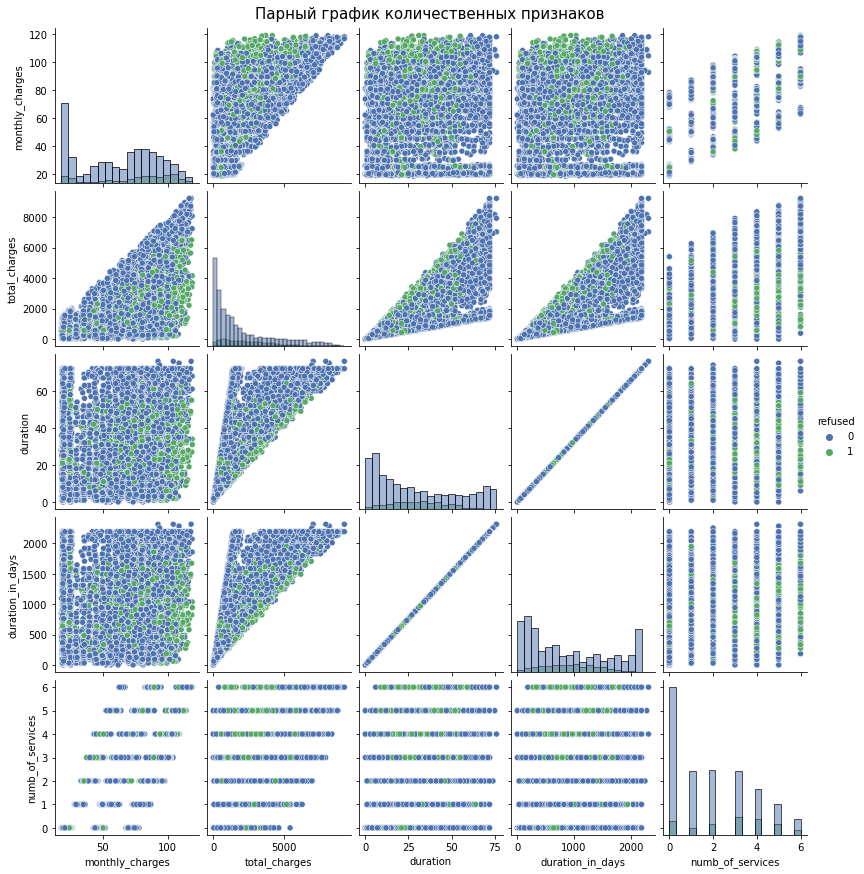

In [52]:
pp = sns.pairplot(data[numb_cols + ['refused']], hue='refused', diag_kind='hist')
pp.fig.set_size_inches(12, 12)
pp.fig.suptitle("Парный график количественных признаков", fontsize=15, y=1.01)
plt.show()

Как видим, особенно выделяется высокая корреляция между продолжительностью и общей суммой выплат.

Для проверки на корреляцию категориальных признаков используем корреляцию Крамера. Напишем функцию для вычисления коэффициента.

In [53]:
def cramers_coefficient(col_1, col_2):
    confusion_matrix = pd.crosstab(col_1, col_2)
    X2 = chi2_contingency(confusion_matrix)[0]
    n = np.sum(confusion_matrix.values)
    minDim = min(confusion_matrix.shape) - 1
    return np.sqrt((X2 / n) / minDim)

In [54]:
cramers_cols = cat_cols + ['refused']
cramers_matrix = np.zeros((len(cramers_cols), len(cramers_cols)))

In [55]:
for i in range(len(cramers_cols) - 1):
    for j in range(i+1, len(cramers_cols)):
        cramers_matrix[i, j] = cramers_coefficient(data[cramers_cols[i]], data[cramers_cols[j]])
cramers_matrix = cramers_matrix + np.diag(np.ones(len(cramers_cols))) + cramers_matrix.T

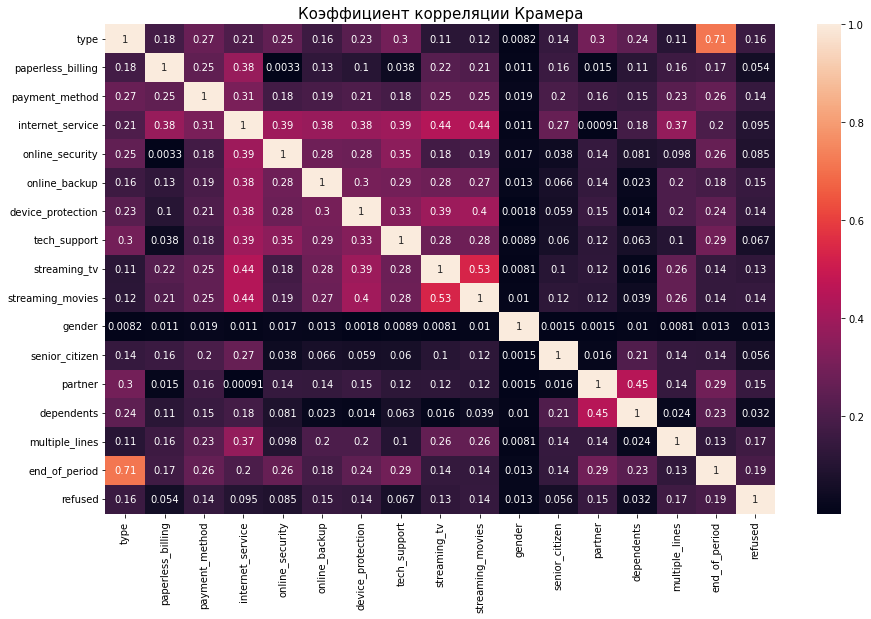

In [56]:
plt.figure(figsize=(15, 9))
sns.heatmap(cramers_matrix, annot=True, xticklabels=cramers_cols, yticklabels=cramers_cols)
plt.title('Коэффициент корреляции Крамера', fontsize=15)
plt.show()

Как видим из тепловой карты, умеренная корреляция наблюдается между использованием разных интернет-сервисов, использованием интренета и стационарной телефонной связи, а также между наличием партнера и детей. С целевым признаком корреляция у всех признаков слабая. 

## Вывод

В данном разделе были произведены следующие действия:
- рассмотрены распределения числовых и категориальных признаков,
- изучен баланс классов,
- рассчитана корреляция признаков (найдена высокая корреляция между числовыми признаками, особенно между `duration` и `total_charges`)

Распределения оставшихся и ушедших клиентов отличаются. Среди ушедших больше доля с платежами выше среднего, продолжительностью пользования услугами от 1 до 5 лет, с большим количество подключенных услуг, оплачивающих по договору на 1-2 года и меющих партнера.

# Обучение моделей

## Разделение датасета на тренировочную и тестовую части

Разобьем датасет на тренировочную и тестовую части в отношении 3:1. Так как в классах присутствует дисбаланс, воспользуемся стратификацией.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('refused', axis=1), data['refused'], test_size=0.25,
                                                    random_state=RANDOM_STATE, stratify=data['refused'])
print(f'Размер тренировочной матрицы признаков: {X_train.shape[0]}x{X_train.shape[1]}.')
print(f'Размер тренировочного вектора целевого признака: {y_train.shape[0]}.')
print(f'Размер тестовой матрицы признаков: {X_test.shape[0]}x{X_test.shape[1]}.')
print(f'Размер тестового вектора целевого признака: {y_test.shape[0]}.')

Размер тренировочной матрицы признаков: 5282x21.
Размер тренировочного вектора целевого признака: 5282.
Размер тестовой матрицы признаков: 1761x21.
Размер тестового вектора целевого признака: 1761.


## Кодирование категориальных признаков

Для кодирования признаков воспользуемся техникой `One-Hot Encoding`.

Создадим два трансформера, один для линейной модели (в этом трансформере помимо кодирования категориальных признаков добавим стандартизацию), другой для случайного леса.

In [58]:
col_transformer_lr = ColumnTransformer(
    [('ohe_features', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
    remainder=StandardScaler(),
    verbose_feature_names_out=False)

col_transformer_rfc = ColumnTransformer(
    [('ohe_features', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
    remainder='passthrough',
    verbose_feature_names_out=False)

In [59]:
col_transformer_lr

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('ohe_features',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['type', 'paperless_billing', 'payment_method',
                                  'internet_service', 'online_security',
                                  'online_backup', 'device_protection',
                                  'tech_support', 'streaming_tv',
                                  'streaming_movies', 'gender',
                                  'senior_citizen', 'partner', 'dependents',
                                  'multiple_lines', 'end_of_period'])],
                  verbose_feature_names_out=False)

Посмотрим результат кодирования и сравним его с необработанными данными.

In [60]:
pd.DataFrame(col_transformer_lr.fit_transform(X_train), columns=col_transformer_lr.get_feature_names_out()).head(10)

type_One year  type_Two year  paperless_billing_Yes  \
0            0.0            1.0                    1.0   
1            0.0            0.0                    1.0   
2            0.0            0.0                    1.0   
3            0.0            0.0                    1.0   
4            1.0            0.0                    1.0   
5            0.0            0.0                    1.0   
6            0.0            0.0                    1.0   
7            0.0            0.0                    1.0   
8            0.0            0.0                    1.0   
9            0.0            0.0                    0.0   

   payment_method_Credit card (automatic)  payment_method_Electronic check  \
0                                     0.0                              0.0   
1                                     1.0                              0.0   
2                                     0.0                              0.0   
3                                     0.0                              0.0   
4                                     1.0                              0.0   
5                                     0.0                              1.0   
6                                     0.0                              1.0   
7                                     0.0                              0.0   
8                                     0.0                              0.0   
9                                     0.0                              1.0   

   payment_method_Mailed check  internet_service_Fiber optic  \
0                          0.0                           1.0   
1                          0.0                           0.0   
2                          0.0                           1.0   
3                          1.0                           0.0   
4                          0.0                           0.0   
5                          0.0                           1.0   
6                          0.0                           1.0   
7                          0.0                           1.0   
8                          0.0                           1.0   
9                          0.0                           1.0   

   internet_service_No  online_security_Yes  online_backup_Yes  ...  \
0                  0.0                  1.0                1.0  ...   
1                  0.0                  1.0                0.0  ...   
2                  0.0                  0.0                1.0  ...   
3                  1.0                  0.0                0.0  ...   
4                  1.0                  0.0                0.0  ...   
5                  0.0                  0.0                0.0  ...   
6                  0.0                  0.0                0.0  ...   
7                  0.0                  1.0                0.0  ...   
8                  0.0                  0.0                1.0  ...   
9                  0.0                  0.0                0.0  ...   

   partner_Yes  dependents_Yes  multiple_lines_Yes  end_of_period_No  \
0          1.0             0.0                 1.0               0.0   
1          0.0             0.0                 0.0               0.0   
2          0.0             0.0                 1.0               0.0   
3          1.0             0.0                 0.0               0.0   
4          1.0             1.0                 0.0               1.0   
5          0.0             0.0                 0.0               0.0   
6          1.0             0.0                 1.0               0.0   
7          0.0             0.0                 1.0               0.0   
8          0.0             0.0                 1.0               0.0   
9          1.0             1.0                 0.0               0.0   

   end_of_period_Yes  monthly_charges  total_charges  duration  \
0                1.0         1.679263       3.198059  1.917912   
1                0.0         0.495950       0.368914  0.303711   
2                0.0       

In [61]:
X_train.head(10)

type paperless_billing             payment_method  \
1280        Two year               Yes  Bank transfer (automatic)   
838   Month-to-month               Yes    Credit card (automatic)   
1958  Month-to-month               Yes  Bank transfer (automatic)   
725   Month-to-month               Yes               Mailed check   
4345        One year               Yes    Credit card (automatic)   
3715  Month-to-month               Yes           Electronic check   
4900  Month-to-month               Yes           Electronic check   
3101  Month-to-month               Yes  Bank transfer (automatic)   
738   Month-to-month               Yes  Bank transfer (automatic)   
4753  Month-to-month                No           Electronic check   

      monthly_charges  total_charges internet_service online_security  \
1280           114.85        8765.35      Fiber optic             Yes   
838             79.20        2851.20              DSL             Yes   
1958            84.85        1781.85      Fiber optic              No   
725             21.25         191.25               No              No   
4345            20.55        1517.21               No              No   
3715            78.50         898.04      Fiber optic              No   
4900            85.70        3256.60      Fiber optic              No   
3101            79.80        2876.79      Fiber optic             Yes   
738             79.35        3332.70      Fiber optic              No   
4753            80.85         528.76      Fiber optic              No   

     online_backup device_protection tech_support  ... streaming_movies  \
1280           Yes               Yes          Yes  ...              Yes   
838             No               Yes          Yes  ...              Yes   
1958           Yes               Yes           No  ...               No   
725             No                No           No  ...               No   
4345            No                No           No  ...               No   
3715            No                No           No  ...              Yes   
4900            No                No           No  ...               No   
3101            No                No           No  ...               No   
738            Yes                No           No  ...               No   
4753            No                No           No  ...              Yes   

      gender senior_citizen  partner dependents multiple_lines duration  \
1280  Female              1      Yes         No            Yes       72   
838     Male              0       No         No             No       36   
1958    Male              0       No         No            Yes       21   
725     Male              1      Yes         No             No        9   
4345    Male              0      Yes        Yes             No       69   
3715    Male              1       No         No             No       11   
4900    Male              1      Yes         No            Yes       38   
3101  Female              0       No         No            Yes       35   
738     Male              1       No         No            Yes       42   
4753  Female              0      Yes        Yes             No        6   

      duration_in_days   end_of_period numb_of_services  
1280              2191             Yes                6  
838               1095  Month-to-month                5  
1958               638  Month-to-month                2  
725                276  Month-to-month                0  
4345              2102              No                0  
3715               337  Month-to-month                1  
4900              1157  Month-to-month                1  
3101              1065  Month-to-month                1  
738               1279  Month-to-month                1  
4753               184  Month-to-month                1  

[10 rows x 21 columns]

## Поиск оптимальных гиперпараметров

Найдем оптимальные гиперпараметры для моделей 3 типов:
- логистическая регрессия (`LogisticRegression`),
- случайный лес (`RandomForestClassifier`),
- градиентный бустинг (`CatBoostClassifier`).

### Логистическая регрессия

In [62]:
lr = LogisticRegression()

Создадим пайплайн. Для данной модели будем искать значение гиперпараметра `C`.

In [63]:
pipe = Pipeline(
    [
        ("encoding", col_transformer_lr),
        ("classify", lr)
    ]
)

param_grid = [{"classify__C": np.logspace(-3, 3, 20)}]

Так как среди числовых признаков есть два линейно зависимых (`duration` и `duration_in_days`), уберем признак `duration`. Среди оставшихся присутствует мультиколлинеарность, поэтому попробуем убрать еще один из признаков.

In [64]:
results = []
lr_numb_cols = [col for col in numb_cols if col != 'duration']
lr_cv = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
lr_cv.fit(X_train.drop(['duration'], axis=1), y_train)
results.append(lr_cv.best_score_)
for drop_col in lr_numb_cols:
    lr_cv = GridSearchCV(pipe, param_grid, cv=4, scoring='roc_auc')
    lr_cv.fit(X_train.drop([drop_col] + ['duration'], axis=1), y_train)
    results.append(lr_cv.best_score_)

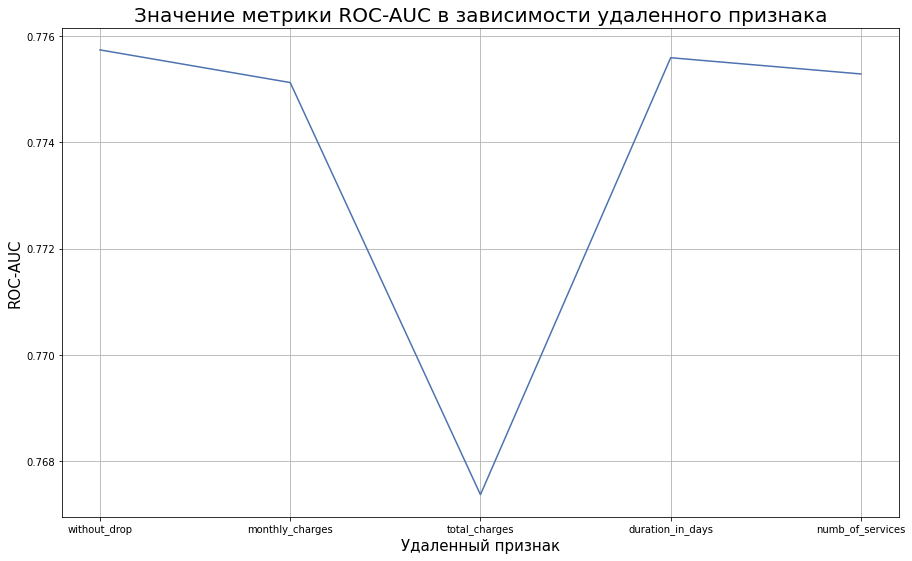

Лучшее значение метрики roc_auc=0.7757 получено для without_drop


In [65]:
plt.figure(figsize=(15, 9))
plt.plot(['without_drop'] + lr_numb_cols, results)
plt.title('Значение метрики ROC-AUC в зависимости удаленного признака', fontsize=20)
plt.xlabel('Удаленный признак', fontsize=15)
plt.ylabel('ROC-AUC', fontsize=15)
plt.grid(True)
plt.show()
print(f'Лучшее значение метрики roc_auc={round(max(results) , 4)} получено для',
      (['without_drop'] + numb_cols)[results.index(max(results))])

In [66]:
lr_cv = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
lr_cv.fit(X_train.drop('duration', axis=1), y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoding',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('ohe_features',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['type',
                                                                          'paperless_billing',
                                                                          'payment_method',
                                                                          'internet_service',
                                                                          'online_security',
                                                                          'online_backup',
                                                                          'device_protection',
                                                                          'tech_support',
                                                                          'streaming_tv',
                                                                          'streaming_movies',...
             param_grid=[{'classify__C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])}],
             scoring='roc_auc')

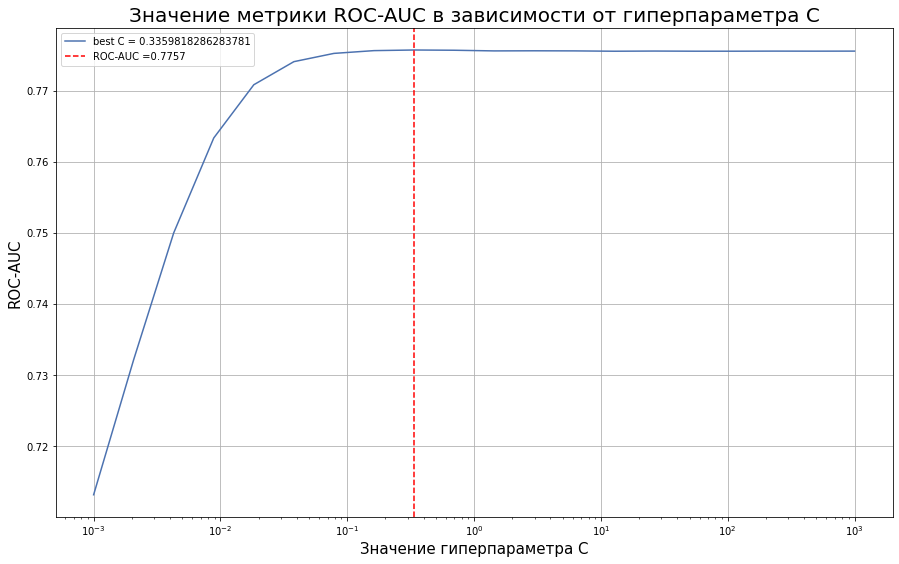

Лучшее значение метрики roc_auc: 0.7757.


In [67]:
plt.figure(figsize=(15, 9))
plt.plot(lr_cv.cv_results_['param_classify__C'].data, lr_cv.cv_results_['mean_test_score'])
plt.xscale('log')
plt.title('Значение метрики ROC-AUC в зависимости от гиперпараметра С', fontsize=20)
plt.xlabel('Значение гиперпараметра C', fontsize=15)
plt.ylabel('ROC-AUC', fontsize=15)
plt.grid(True)
plt.axvline(x=lr_cv.best_params_['classify__C'], color='r', linestyle='--')
plt.legend(['best C = ' + str(lr_cv.best_params_['classify__C']), 'ROC-AUC =' + str(round(lr_cv.best_score_, 4))])
plt.show()
print(f'Лучшее значение метрики roc_auc: {round(lr_cv.best_score_, 4)}.')

### Случайный лес

In [68]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE)

Создадим пайплайн. Для данной модели будем искать значение гиперпараметров `max_depth` и `n_estimators`.

In [69]:
pipe = Pipeline(
    [
        ("encoding", col_transformer_rfc),
        ("classify", rfc)
    ]
)

param_grid = [{"classify__max_depth": np.arange(5, 31),
               "classify__n_estimators": np.arange(100, 1001, 50)}]

In [70]:
%%time
rfc_cv = RandomizedSearchCV(pipe, param_grid, n_iter=20, refit=True, cv=4, scoring='roc_auc', random_state=RANDOM_STATE)
rfc_cv.fit(X_train, y_train)

Wall time: 3min 38s


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('encoding',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe_features',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'internet_service',
                                                                                'online_security',
                                                                                'online_backup',
                                                                                'device_protection',
                                                                                'tech_support',
                                                                                'streaming_tv',
                                                                                'streaming_movie...
                                                                verbose_feature_names_out=False)),
                                             ('classify',
                                              RandomForestClassifier(random_state=100423))]),
                   n_iter=20,
                   param_distributions=[{'classify__max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                         'classify__n_estimators': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000])}],
                   random_state=100423, scoring='roc_auc')

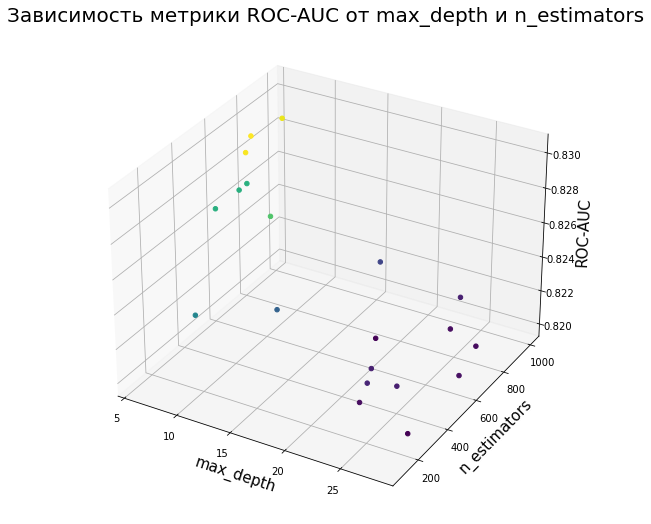

Лучшее значение метрики ROC-AUC для модели случайный лес с параметром max_depth=8 и параметром n_estimators=650, равно 0.8303.


In [71]:
x_s = rfc_cv.cv_results_['param_classify__max_depth'].data
y_s = rfc_cv.cv_results_['param_classify__n_estimators'].data
z_s = rfc_cv.cv_results_['mean_test_score']
fig = plt.figure(figsize=(15, 9))
ax_3d = fig.add_subplot(projection='3d')
ax_3d.set_title('Зависимость метрики ROC-AUC от max_depth и n_estimators', fontsize=20)
ax_3d.set_xlabel('max_depth', fontsize=15)
ax_3d.set_ylabel('n_estimators', fontsize=15)
ax_3d.set_zlabel('ROC-AUC', fontsize=15)
ax_3d.scatter(x_s, y_s, z_s, c=z_s, depthshade=False)
plt.show()

print('Лучшее значение метрики ROC-AUC для модели случайный лес с параметром max_depth=',
      rfc_cv.best_params_['classify__max_depth'], ' и параметром n_estimators=', 
      rfc_cv.best_params_['classify__n_estimators'], ', равно ',
      round(rfc_cv.best_score_, 4), '.', sep='')

Посмотрим на значимость признаков.

In [72]:
col_transformer_rfc.fit(X_train, y_train)
importance_of_features = pd.DataFrame({'features': col_transformer_rfc.get_feature_names_out(),
                           'importance': rfc_cv.best_estimator_['classify'].feature_importances_}).\
                                        sort_values(by='importance', ascending=False)

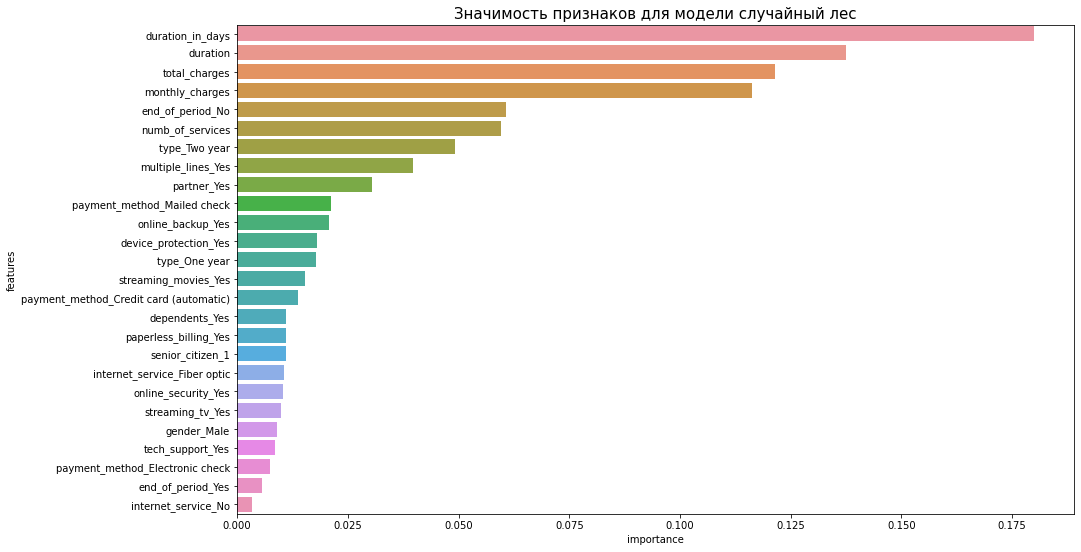

In [73]:
fig = plt.figure(figsize=(15, 9))
ax = sns.barplot(data=importance_of_features, y='features', x='importance')
plt.title("Значимость признаков для модели случайный лес", fontsize=15)
plt.show()

### Градиентный бустинг

Подберем оптимальные геиперпараметры для модели `CatBoostClassifier` с помощью библиотеки `Optuna`.

In [74]:
def objective(trial, X_train=X_train, y_train=y_train):

    params = {
        'iterations' : trial.suggest_int("iterations", 100, 1000),
        'learning_rate' : trial.suggest_float("learning_rate", 1e-3, 3e-1, log=True),
        'depth' : trial.suggest_int("depth", 4, 10),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-2, 10),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 5),
        'auto_class_weights': 'Balanced',
        'verbose' : False,
        'eval_metric' : 'AUC',
        'loss_function' : 'Logloss'
    }
    boost_model = CatBoostClassifier(cat_features=cat_cols, random_state=RANDOM_STATE, **params)

    scores = cross_val_score(boost_model, X_train, y_train, scoring='roc_auc', cv=4)
    return scores.mean()

In [75]:
# Ниже можно загрузить модель с лучшим результатом

In [76]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=RANDOM_STATE)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

Wall time: 2h 10min 37s


In [78]:
print(f'Лучшее значение метрики ROC-AUC={round(study.best_trial.value, 4)} получено со следующими гиперпараметрами:\n',
      '\n'.join(['- ' + key + '=' + str(study.best_trial.params[key]) for key in study.best_trial.params]))

Лучшее значение метрики ROC-AUC=0.9046 получено со следующими гиперпараметрами:
 - iterations=746
- learning_rate=0.1586491968773878
- depth=4
- subsample=0.976812080016002
- l2_leaf_reg=0.4402441689594334
- min_data_in_leaf=1


Построим визуализацию поиска и значимости гиперпараметров.

In [79]:
optuna.visualization.plot_optimization_history(study)

In [80]:
optuna.visualization.plot_param_importances(study)

Обучим модель с ипользованием лучших гиперпараметров.

In [81]:
boost_model = CatBoostClassifier(cat_features=cat_cols, **study.best_trial.params,
                                 random_state=RANDOM_STATE, verbose=False)

In [82]:
boost_model.fit(X_train, y_train)

In [83]:
import pickle

with open("boost_model.pkl", "wb") as f:
    pickle.dump(boost_model, f)

In [202]:
# Здесь можно загрузить обученную модель CatBoostClassifier
# ! pip install gdown
# import pickle
# import gdown

# url = 'https://drive.google.com/u/0/uc?id=1arJAbxLkqd1Ef3ItRIwoEEGQOWX-ByAF&confirm=t'
# output = 'boost_model.pkl'
# gdown.download(url, output, quiet=False)

# with open("boost_model.pkl", "rb") as f:
#     boost_model = pickle.load(f)

Посмотрим на значимость признаков.

In [84]:
importance_of_features = pd.DataFrame({'features': X_train.columns,
                                       'importance': boost_model.get_feature_importance()}).\
                                            sort_values(by='importance', ascending=False)

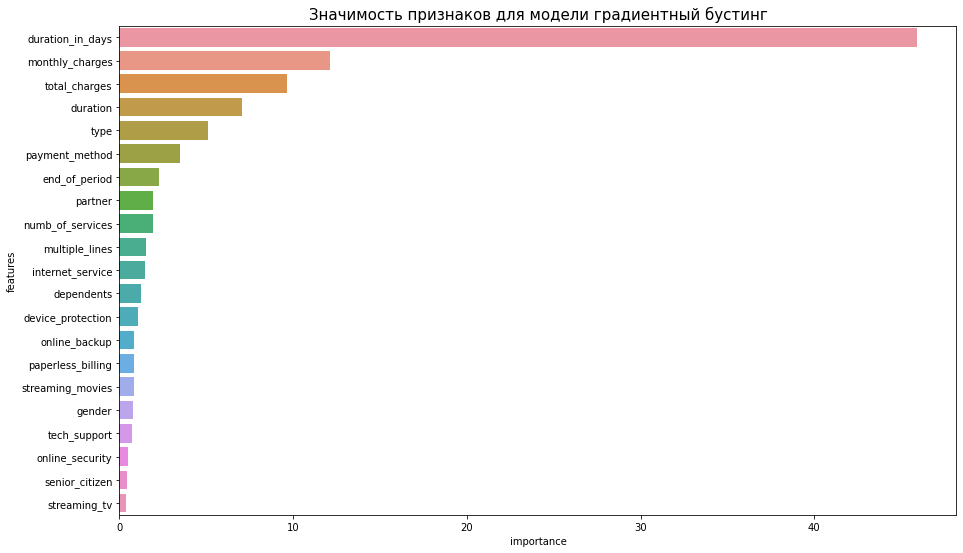

In [85]:
fig = plt.figure(figsize=(15, 9))
ax = sns.barplot(data=importance_of_features, y='features', x='importance')
plt.title("Значимость признаков для модели градиентный бустинг", fontsize=15)
plt.show()

## Выбор лучшей модели

Посмотрим на значения метрики `ROC-AUC` для всех моделей.

In [86]:
models_names = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']
results = {'ROC-AUC' : [round(lr_cv.best_score_, 4),
                        round(rfc_cv.best_score_, 4),
                        round(study.best_trial.value, 4)]}
models_results = pd.DataFrame(results, index=models_names)
models_results

ROC-AUC
LogisticRegression       0.7757
RandomForestClassifier   0.8303
CatBoostClassifier       0.9046

Из обученных моделей лучший результат показала модель градиентного бустинга (`CatBoostClassifier`). 

In [87]:
best_model = boost_model

## Вывод

В данном разделе были произведены следующие действия:
- произведено разделение датасета на тренировочную и тестовую выборки в отношении 3:1,
- создан трансформер для кодирования категориальных признаков для моделей логистическая регрессия и случайный лес,
- произвелен поиск оптимальных гиперпараметров для 3 моделей (логистическая регрессия, случайный лес и градиентный бустинг) с использованием кросс-валидации,
- на основании полученных значений метрики `ROC-AUC` выбрана лучшая модель (модель градиентного бустинга `CatBoostClassifier`).

# Тестирование выбранной модели

## Проверка лучшей модели на тестовой выборке

Проверим лучшую модель на тестовой выборке.

In [88]:
y_pred = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print(f'Значение метрики ROC-AUC на тестовой выборке равно {round(roc_auc, 4)}')

Значение метрики ROC-AUC на тестовой выборке равно 0.9343


Построим `ROC` кривую.

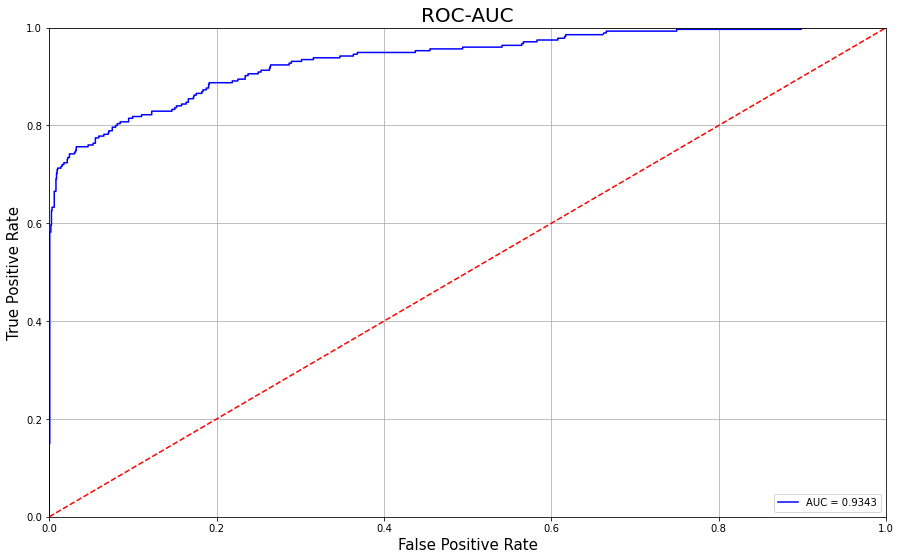

In [89]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
plt.figure(figsize=(15, 9))
plt.title('ROC-AUC', fontsize=20)
plt.plot(fpr, tpr, 'b', label = f'AUC = {round(roc_auc, 4)}' )
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.show()

Полученный результат метрики `ROC-AUC` выше заданного в требованиях.

## Оценка результатов на тестовой выборке

Создадим датафрейм с неправильными ответами (результат прогнозирования берется со значением `threshold` по умолчанию).

In [91]:
y_pred = pd.Series(best_model.predict(X_test), index=y_test.index)
wrong_index = y_test != y_pred
wrong = pd.concat([X_test[wrong_index], y_test[wrong_index], y_pred[wrong_index]], axis=1).rename(columns={'refused' : 'test',
                                                                                                   0 : 'predict'})

In [92]:
wrong

type paperless_billing           payment_method  \
2074  Month-to-month               Yes  Credit card (automatic)   
2389        One year                No         Electronic check   
2003        Two year               Yes         Electronic check   
6336  Month-to-month               Yes         Electronic check   
4502  Month-to-month               Yes         Electronic check   
...              ...               ...                      ...   
1384  Month-to-month               Yes         Electronic check   
4567  Month-to-month               Yes         Electronic check   
876   Month-to-month                No         Electronic check   
298   Month-to-month               Yes         Electronic check   
4847  Month-to-month               Yes         Electronic check   

      monthly_charges  total_charges internet_service online_security  \
2074           108.15        3787.41      Fiber optic             Yes   
2389            85.45        3845.25              DSL             Yes   
2003            95.25        2571.75      Fiber optic              No   
6336            74.30         600.34      Fiber optic              No   
4502            96.80        4356.00      Fiber optic              No   
...               ...            ...              ...             ...   
1384            69.25         224.37      Fiber optic              No   
4567           105.35        1438.03      Fiber optic              No   
876            105.10        1911.77      Fiber optic             Yes   
298             74.55        2032.98              DSL              No   
4847            76.25        2992.05      Fiber optic              No   

     online_backup device_protection tech_support  ... senior_citizen partner  \
2074           Yes                No          Yes  ...              1      No   
2389            No               Yes          Yes  ...              0     Yes   
2003            No               Yes           No  ...              0      No   
6336            No                No           No  ...              0     Yes   
4502            No                No           No  ...              0      No   
...            ...               ...          ...  ...            ...     ...   
1384            No                No           No  ...              0     Yes   
4567           Yes                No          Yes  ...              0      No   
876             No               Yes          Yes  ...              0      No   
298             No               Yes           No  ...              0     Yes   
4847            No                No           No  ...              1      No   

     dependents  multiple_lines duration duration_in_days   end_of_period  \
2074         No              No       34             1036  Month-to-month   
2389        Yes             Yes       45             1371              No   
2003         No              No       27              820              No   
6336        Yes             Yes        8              245  Month-to-month   
4502         No             Yes       45             1371  Month-to-month   
...         ...             ...      ...              ...             ...   
1384         No              No        3               92  Month-to-month   
4567         No             Yes       13              395  Month-to-month   
876          No              No       17              518  Month-to-month   
298         Yes             Yes       27              822  Month-to-month   
4847         No             Yes       36             1095  Month-to-month   

      numb_of_services  test predict  
2074                 5     1       0  
2389                 5     1       0  
2003                 3     1       0  
6336                 0     1       0  
4502                 2     1       0  
...                ...   ...     ...  
1384                 0     1       0  
4567                 4     1       0  
876                  5     1       0  
298                  3     1       0  
4847   

Посмторим на распределение в численных признаках (у них более высокая значимость) среди неправильных ответов.

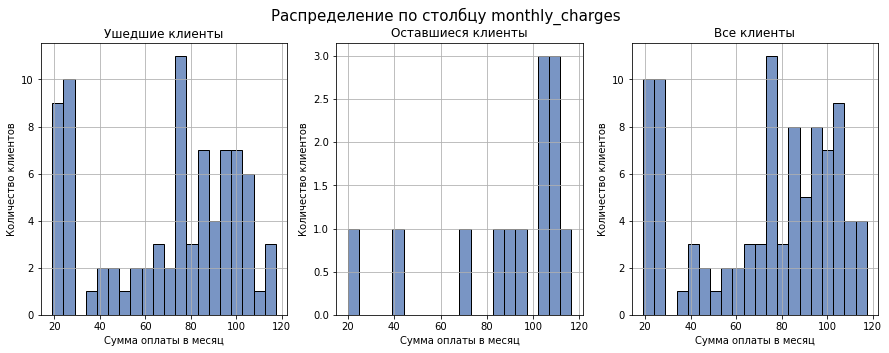

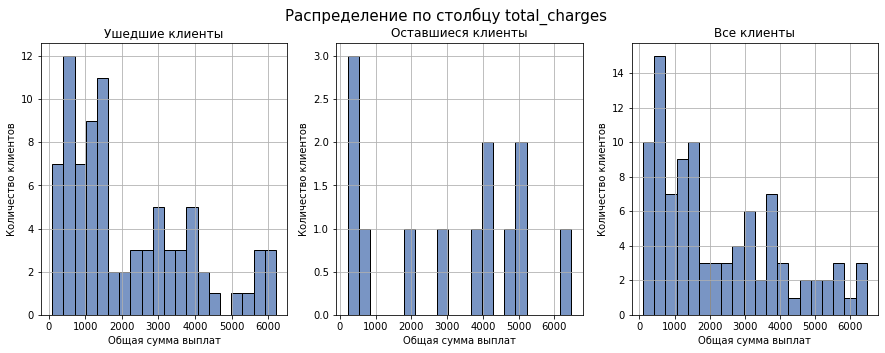

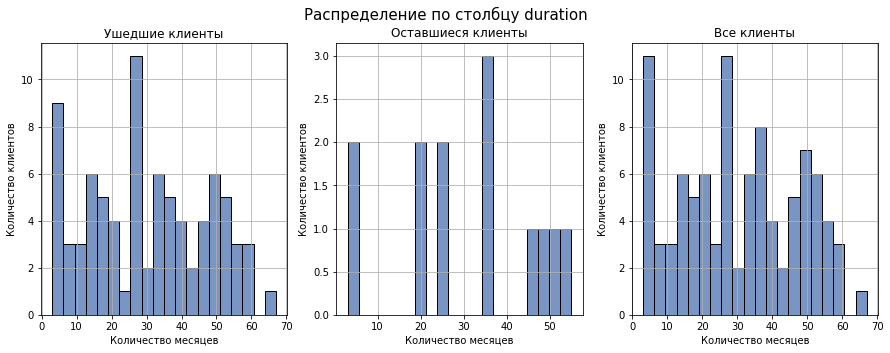

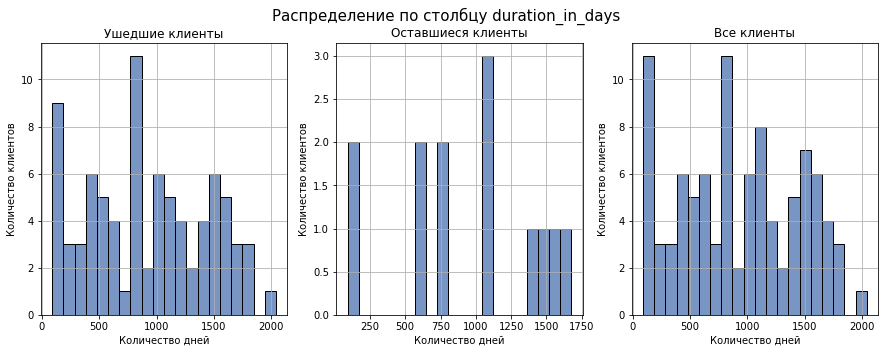

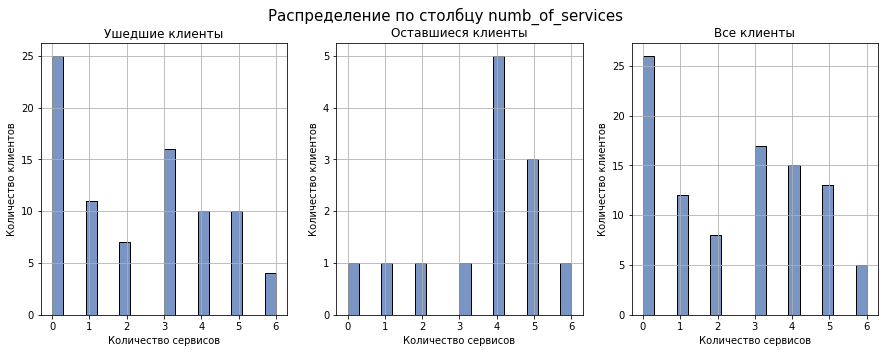

In [95]:
xlabel_dict = {'monthly_charges' : 'Сумма оплаты в месяц',
               'total_charges' : 'Общая сумма выплат',
               'duration' : 'Количество месяцев',
               'duration_in_days' : 'Количество дней',
               'numb_of_services' : 'Количество сервисов'}
for col in numb_cols:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f'Распределение по столбцу {col}', fontsize=15)
    for i, customer_type in enumerate(['Ушедшие клиенты', 'Оставшиеся клиенты', 'Все клиенты']):
        sns.histplot(wrong.query('test != @i')[col], ax=axes[i], bins=20)
        axes[i].set_title(customer_type, fontsize=12)
        axes[i].set(xlabel=xlabel_dict[col], ylabel='Количество клиентов')
        axes[i].grid(True)
    plt.show()

Как видим, при определении уходящих клиентов модель чаще ошибалась при маленькой ежемесячной плате и нулевому количеству услуг. В остальных случаях распределения довольно схожи.

## Поиск оптимального значения `threshold`

Определим оптимальное значение порога вероятности (`threshold`), выше которого модель будет считать, что клиент собирается уйти. Предположим, что клиент останется, если ему предложить скидку. Напишем функцию которая будет считать значение дохода, с учетом скидки для собирающихся по предсказанию уходить и клиентов которые ушли из-за того, что им не предоставили скидку (в результате неправильного предсказания).

In [108]:
def profit(x_test, y_test, y_pred, discount):
    ind_pred_1 = y_pred == 1
    ind_pred_right_0 = (y_pred == 0) * (y_pred == y_test)
    all_sum = x_test.loc[ind_pred_1, 'monthly_charges'].sum() * (1 - discount / 100) +\
                                                        x_test.loc[ind_pred_right_0, 'monthly_charges'].sum()
    return all_sum

In [111]:
def threshold_search(x_test, y_test, model, discount, bins=20):
    delta = 1 / bins
    thresholds = []
    profits = []
    for i in range(bins + 1):
        threshold = delta * i
        model.set_probability_threshold(threshold)
        y_pred = model.predict(x_test)
        profits.append(profit(x_test, y_test, y_pred, discount))
        thresholds.append(threshold)
    return thresholds, profits

Рассмотрим пороговые значения для 3 вариантов скидок: 5%, 10%, 20%.

Наибольший доход для скидки 5% получается при уровне threshold=0.05.
Наибольший доход для скидки 10% получается при уровне threshold=0.05.
Наибольший доход для скидки 20% получается при уровне threshold=0.35.


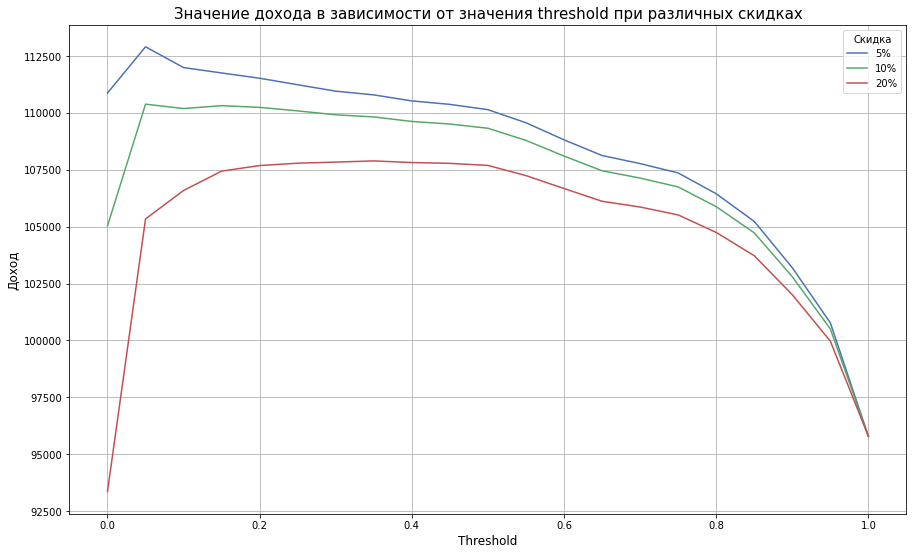

In [136]:
plt.figure(figsize=(15,9))
plt.title(f'Значение дохода в зависимости от значения threshold при различных скидках', fontsize=15)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Доход', fontsize=12)
for discount in [5, 10, 20]:
    thresholds, profits = threshold_search(X_test, y_test, best_model, discount)
    best_threshold = thresholds[profits.index(max(profits))]
    plt.plot(thresholds, profits)

    plt.grid(True)
    print(f'Наибольший доход для скидки {discount}% получается при уровне threshold={round(best_threshold, 2)}.')
plt.legend(['5%', '10%', '20%'], title='Скидка')
plt.show()

## Вывод

В данном разделе было произведено прогнозирование на тестовой выборке. Полученный результат выше заданного (`ROC-AUC`=0,93), что говорит о том, что полученная модель может быть использована для прогнозирования оттока клиентов. Так же были рассмотрены неправильно определенные объекты. Среди них можно выделить случаи ушедших клиентов с низкой ежемесячной платой. 

Помимо этого для полученной модели была написана функция, которая позволяет определить доход для разных значений `threshold` (порог вероятности, выше которого модель определяет клиента, как собирающегося уйти). С ее помощью для можно подобрать значение этого порога для определенного значения скидки при условии максимального дохода (при условии, что при получении этой скидки, клиент останется).

Для улучшения качества модели рекомендуется увеличить количество данных для обучения.

# Отчет по работе

## Отличия итогового решения от плана

В разделе `Предобработка данных` итогового решения не осуществлен поиск и обработка выбросов и некорректных значений. Отсутствие выбросов и некорректных значений можно увидеть по гистограммам и диаграммам при рассмотрении распределений количественных и категориальных признаков в разделе `Исследовательский анализ`.

Остальные пункты плана в итоговом решении выполнены.

## Трудности, возникшие в результате выполнения работы.

Основная проблема, возникшая при выполнении задания - достижение порогового значения метрики `ROC-AUC`. Изначально признак длительности пользования услугами был представлен только в количестве месяцев (`duration`), в результате чего значение метрики `ROC-AUC` при тестировании модели получалось равным `0.8465`, что немного ниже заданного в задании значения. Проблема была решена добавлением признака продолжительности пользования услугами в днях (`duration_in_days`), благодаря чему, метрика на тестировании выросла до значения `0.9343`.

В остальных разделах трудностей не возникало.

## Ключевые шаги

На достижение высокого значения метрики особенно повлияли следующие действия:
- создание новых признаков,
- подбор гиперпараметров моделей.

В ходе решения было создано 4 новых признака: `duration` (продолжительность пользования услугами оператора связи в месяцах), `duration_in_days` (продолжительность пользования услугами оператора связи в днях), `end_of_period` (признак, указывающий закончился ли период договора для пользователей, оплачивающих услуги по договору на 1 или 2 года) и `numb_of_services` (количество подключенных интернет сервисов). Особенно существенное увеличение метрики оказал признак `duration_in_days`.

Поиск гиперпараметров модели, показавшей лучшее значение метрики (`CatBoostClassifier`), осуществлялся с помощью фреймворка для автоматизированного поиска оптимальных гиперпараметров `Optuna`. В ходе поиска фреймворк проверил 100 различных комбинаций, выполняя для каждой расчет метрики `ROC-AUC` с использованием кросс-валидации. Найденные с помощью фреймворка гиперпараметры позволили существенно увеличить качество модели.

## Описание модели машинного обучения

В ходе выполнения работы лучший результат показала модель градиентного бустинга `CatBoostClassifier`. В результате поиска были получены следующие гиперпараметры:
- iterations (количество итераций) : 746
- learning_rate (скорость обучения): 0.1586491968773878
- depth (максимальная глубина деревьев) : 4
- subsample (часть исходной выборки, отбираемая для обучения каждого дерева) : 0.976812080016002
- l2_leaf_reg (коэффициент регуляризации L2) : 0.4402441689594334
- min_data_in_leaf (минимальное количество обучающих сэмплов в листе) : 1

Так же в параметре `cat_features` указываются категориальные признаки:
`type`, `paperless_billing`, `payment_method`, `internet_service`, `online_security`, `online_backup`, `device_protection`,  `tech_support`, `streaming_tv`, `streaming_movies`, `gender`, `senior_citizen`, `partner`, `dependents`, `multiple_lines`, `end_of_period`.

## Исползуемые при обучении признаки

Исходные:
- `type` - тип оплаты: ежемесячный, договор на 1 год, договор на 2 года;
- `paperless_billing` - безналичный расчет;
- `payment_method` - способ оплаты: банковский перевод, электронный счет, счет по почте, кредитной картой;
- `monthly_charges` - ежемесячные траты на услуги;
- `total_charges` - всего потрачено денег на услуги;
- `internet_service` - тип полключения к интернету: через телефонную линию, оптоволоконный кабель или отсутствует;
- `online_security` - блокировка небезопасных сайтов;
- `online_backup` - облачное хранилище файлов для резервного копирования данных;
- `device_protection` - антивирус;
- `tech_support` - выделенная линия технической поддержки;
- `streaming_tv` - стриминговое телевидение;
- `streaming_movies` - каталог фильмов;
- `gender` - пол клиента;
- `senior_citizen` - наличие пенсионного статуса по возрасту;
- `partner` - наличие супруга(и);
- `dependents` - наличие иждивенцев;
- `multiple_lines` - наличие возможности ведения параллельных линий во время звонка.

Сгенерированные:
- `duration` - продолжительность пользования услугами связи в месяцах;
- `duration_in days` - продолжительность пользования услугами связи в днях;
- `end_of_period` - статус действия периода договора для пользователей, оплачивающих услуги по договору на 1 или 2 года, для пользователей, использующих ежемесячный тип оплаты указывается значение `Month-to-month`;
- `numb_of_services` - количчество используемых интернет-сервисов.

Признаки `type`, `paperless_billing`, `payment_method`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `gender`, `senior_citizen`, `partner`, `dependents`, `multiple_lines`, `end_of_period` имеют тип `object`.

Признаки `monthly_charges`, `total_charges` имеют тип `float`.

Признаки `duration`, `duration_in days`, `numb_of_services` имеют тип `int`.

## Предобработка данных

В таблицах с данными по подключенным интернет-сервисам и наличию возможности ведения параллельных линий во время звонка отсутствовали данные по некоторым клиентам. В результате, при слиянии таблиц в столбцах `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines` образовались пропуски, которые были заполнены значениями `No` из предположения, что отсутсвие данных об этих пользователях в таблицах говорит об отсутствии у них этих услу.

В столбце `total_charges` может отсутствовать значение (вместо числа стоять строка из пробелов). Такие значения появляются, если клиент только подключился к услугам, соответственно такие значения были заменены на `0`.

## Константы, используемые в работе

В ходе работы были использованы следующие константные значения:
- размер тестовой выборки равный 0.25;
- случайное состояние (`RANDOM_STATE`) равное `100423`.